Listwise recomentation using DDPG
* Paper https://arxiv.org/pdf/1801.00209.pdf
* Code reference from original paper https://github.com/luozachary/drl-rec.
* Code in this implementation kept the DDPG Actor-Critic frame work in the original paper, with a few modidications to improve performance: The neural network framework as been simplified to reduce training time. Reward function modified to predict {-1: skip, 0: not viewed, 1: listened}, Actor noise with decay has been added to improve performance. Added deep and wide style state representation. Also, pytorch was used instead of tensorflow. 


In [6]:
from collections import defaultdict
import os
import pickle
import random
import requests
import time
import tqdm
import scipy
import scipy.sparse as sp

from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import torch_optimizer as optim
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
from utils import Prioritized_Buffer

## 0. Data Preprocess

In [7]:
with open('../data/all_session_skips_train.pkl','rb') as f:
    skips_train = pickle.load(f)
with open('../data/all_session_skips_test.pkl','rb') as f:
    skips_test = pickle.load(f)
with open('../data/all_session_tracks_train.pkl','rb') as f:
    tracks_train = pickle.load(f)
with open('../data/all_session_tracks_test.pkl','rb') as f:
    tracks_test = pickle.load(f)

In [8]:
reward_train = -(np.array(skips_train)-0.5) * 2
reward_test = -(np.array(skips_test)-0.5) * 2


In [9]:
len(skips_train)

3308400

In [10]:
# Re-split train test by adding the first 10 tracks of test set into train data. 
max_train = 1000000 #len(tracks_train)
max_test = 1000
train_data = []
test_data = []
for i in range(max_train):
    for j, track in enumerate(tracks_train[i]): 
        
        train_data.append([i,track, reward_train[i][j]])
        
for i in range(max_test):
    for j, track in enumerate(tracks_test[i]): 
        if j<10:
            train_data.append([max_train+i,track, reward_test[i][j]])
        else:
            break

for i in range(max_test):
    for j, track in enumerate(tracks_test[i]): 
        if j>=10:
            test_data.append([i,track])
        else:
            pass
print(np.array(train_data).shape, np.array(test_data).shape)

# del skips_train, skips_test, tracks_train, tracks_test
# import gc; gc.collect()

(20010000, 3) (10000, 2)


In [11]:
skip_test_actual = np.array(skips_test)[:max_test, 10:20]

In [7]:
train_data = np.array(train_data)

In [8]:
from scipy.sparse import csr_matrix

user_num = int(np.array(train_data)[:,0].max()) + 1
item_num = int(np.array(train_data)[:,1].max()) + 1

train_matrix = csr_matrix((train_data[:,2], (train_data[:,0], train_data[:,1]))
                       , shape=(user_num, item_num))

In [9]:
user_num = int(np.array(train_data)[:,0].max()) + 1
item_num = int(np.array(train_data)[:,1].max()) + 1

# train_mat = defaultdict(int)
test_mat = defaultdict(int)
# for user, item in train_data:
#     train_mat[user, item] = 1
for user, item in test_data:
    test_mat[user, item] = 1
# train_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
# dict.update(train_matrix, train_mat)
test_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
dict.update(test_matrix, test_mat)

print(train_matrix.shape, test_matrix.shape)

(1001000, 103909) (1001000, 103909)


## 1. Evaluation data

In [10]:
# Prepare data for test
class BatchLoader(td.Dataset):
    def __init__(self, positive_data, item_num, data_mat, negative_samples=99):
        super(BatchLoader, self).__init__()
        self.positive_data = np.array(positive_data)
        self.item_num = item_num
        self.data_mat = data_mat
        self.negative_samples = negative_samples
        self.reset()
        
    def reset(self):
        valid_data = []
        for user, positive in self.positive_data:
            valid_data.append([user, positive])
            # for seq recomendation only. 
            for i in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.data_mat:
                    negative = np.random.randint(self.item_num)
                valid_data.append([user, negative])
        labels = np.zeros(len(self.positive_data) * (1 + self.negative_samples))
        labels[::1+self.negative_samples] = 1
        self.data = np.concatenate([
            np.array(valid_data), 
            np.array(labels)[:, np.newaxis]], 
            axis=1
        )
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = {
            "user": user,
            "track": item,
            "label": np.float32(label),
        }
        return output

valid_dataset = BatchLoader(
    np.array(test_data), 
    item_num, 
    test_matrix,
    negative_samples=0
)
valid_loader = td.DataLoader(valid_dataset, batch_size=len(test_data), shuffle=False)

In [11]:
len(test_data)

10000

In [12]:
# Define evaluation metric
def to_np(tensor):
    return tensor.detach().cpu().numpy()

def hit_metric(recommended, actual):
    return int(actual in recommended)

def dcg_metric(recommended, actual):
    if actual in recommended:
        index = recommended.index(actual)
        return np.reciprocal(np.log2(index + 2))
    return 0

def aa(pred, act, k=10):
    L = 1.0*(np.array(pred) == np.array(act))
    A = np.zeros(k)
    for i in range(k):
        A[i] = np.mean(L[0:i+1])
    AA = np.sum(A*L) / k
    return AA



# Binaray eval
def run_evaluation(net, state_representation, training_env_memory, loader=valid_loader):
    hits = []
    dcgs = []
    aa_1=[]
    aa_10_batches=[]
    acc_batches=[]
    test_env = Env(test_matrix)
    test_env.memory = training_env_memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    
    for batch in loader:
        action_emb = net(state_repr(user, memory))
        scores, action = net.get_action(
            batch['user'], 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]), 
            state_representation, 
            action_emb,
            batch['track'].long(), 
            return_scores=True,
            add_noise=False
        )
        user, memory, reward, done = test_env.step(action)
        
#         import pdb;pdb.set_trace()
        s_a = scores.reshape(1000,10).detach().numpy()
#         pred = 1.0*( s_a.argsort(axis=1).argsort(axis=1)>=4) #top 6 of each user
        pred = 1.0*(s_a>0)
        act = (1-skip_test_actual)
        
        # get acc
        acc=1.0*(pred==act)
        acc_by_k = acc.mean(axis=0)

        #get aa
        aa_i = []
        for i in range(len(act)):
            aa_i .append( aa(pred[i], act[i], k=10) )

    return np.mean(aa_i), acc_by_k


## 3. Model

In [13]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
SUB = ''

In [14]:
EMBEDDING_SIZE = 64
HIDDEN_SIZE=128
TAU = 0.01
SUB = ''

In [15]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
SUB = '_r-1_-0.5_1'

In [13]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
DROPOUT=0.5
DECAY=1.0
SUB = '_noise'+str(DROPOUT)+'_nodecay'

In [17]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
DROPOUT=0.5
SUB = '_noise'+str(DROPOUT)+'_decay0.9'

In [ ]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
DROPOUT=0.5
SUB = '_r-0.5_0_1_noise'+str(DROPOUT)+'_decay0.9'

In [13]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
DROPOUT=0.3
DECAY=0.9
SUB = '_r-0.5_0_1_noise'+str(DROPOUT)+'_decay0.9'

In [13]:
EMBEDDING_SIZE = 32
HIDDEN_SIZE=16
TAU = 0.4
DROPOUT=0.5
DECAY=0.9
SUB = '_r-0.5_0_1_noise'+str(DROPOUT)+'_decay0.9'

In [15]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE=16
TAU = 0.4
DROPOUT=0.5
SUB = 'lr=e-5'

In [14]:
file_name='rl_baseline_skip_%d_%d_%d_%s.csv' % (EMBEDDING_SIZE, HIDDEN_SIZE, int(TAU*100), SUB)
print('predicting for {file_name}'.format(file_name=file_name))

predicting for rl_baseline_skip_32_16_40__r-0.5_0_1_noise0.5_decay0.9.csv


In [ ]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.memory = np.ones([user_num, 5]) * item_num

    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = [] #keep track of what track has been listened
        self.related_items = np.argwhere(self.matrix[self.user_id] != 0)[:, 1]
        self.related_nonskip_items = np.argwhere(self.matrix[self.user_id] == 1)[:, 1]
        self.num_rele = len(self.related_items)
        # choose a new item
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items)), self.num_rele)
        self.candidates = np.zeros(self.num_rele * 2)
        self.candidates[::2] = self.related_items
        self.candidates[1::2] = self.nonrelated_items
        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :])
    
    def step(self, action, action_emb=None, buffer=None):        
        a_item = to_np(action)[0]
        if a_item in self.related_items:
            if a_item in self.related_nonskip_items:
                reward = 1
#                 print('get reward')
            else:
                reward = -1 #penalize skipped
#                 print('get penalty')
        else: 
            reward = 0
        
        self.viewed_items.append(to_np(action)[0])
        if reward:
            if len(action) == 1:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action]
            else:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action[0]]
                
        if len(self.viewed_items) == len(self.related_items):
            done = 1
        else:
            done = 0
            
        if buffer is not None:
            buffer.push(np.array([self.user_id]), np.array(self.memory[[self.user_id], :]), to_np(action_emb)[0], 
                        np.array([reward]), np.array([self.user_id]), self.memory[[self.user_id], :], np.array([reward]))

        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :]), reward, done

class Actor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
            # Note the original paper implemented an RNN unit here
        )
        self.dropout_decay=DECAY
        self.dropout=DROPOUT
        self.initialize()

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   action_emb,
                   items=torch.tensor([i for i in range(item_num)]),
                   return_scores=False,
                   add_noise = False
                  ):
        state = state_repr(user, memory)
        #dot product state and action
        cosine = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                           action_emb.T.unsqueeze(0)
                          )
        
        
        if add_noise:
            # 
            self.dropout = self.dropout*self.dropout_decay
            dropout = self.dropout*0.9
            mask = torch.bernoulli(torch.ones(size=cosine.shape)*(1-self.dropout))
            cosine = cosine*mask
            
        scores = cosine.squeeze(0)
        
        
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))


class Critic(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
            # Note the original paper implemented an RNN unit here
        )
        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

class State(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()

    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())
        item_embeddings = self.item_embeddings(memory.long())
        item_ave = torch.sum(item_embeddings, dim=1)
        # user state represented as user_embedding, item_userviewed, and the product of the 2, as in deep and wide recomendation
        return torch.cat((user_embedding, user_embedding * item_ave, item_ave), 1)



# training main
torch.manual_seed(2)

state_repr = State(user_num, item_num, EMBEDDING_SIZE, HIDDEN_SIZE)
policy = Actor(EMBEDDING_SIZE, HIDDEN_SIZE)
value_net  = Critic(EMBEDDING_SIZE * 3, EMBEDDING_SIZE, HIDDEN_SIZE)
replay_buffer = Prioritized_Buffer(10000)

target_value_net  = Critic(EMBEDDING_SIZE * 3, EMBEDDING_SIZE, HIDDEN_SIZE)
target_policy = Actor(EMBEDDING_SIZE, HIDDEN_SIZE)

value_criterion  = nn.MSELoss()
value_optimizer  = optim.Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer = optim.Ranger(policy.parameters(), lr=1e-4)
state_repr_optimizer = optim.Ranger(state_repr.parameters(), lr=1e-4)


def update(training_env, 
                step=0,
                batch_size=512, 
                gamma=0.9,
               ):
    beta = min(1.0, TAU + step * (1.0 - TAU) / 1000)
    u, m, a, r, nu, nm, done = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(u)
    memory      = torch.FloatTensor(m)
    action      = torch.FloatTensor(a)
    reward      = torch.FloatTensor(r)
    next_user   = torch.FloatTensor(nu)
    next_memory = torch.FloatTensor(nm)

    done = torch.FloatTensor(done)
    
    state       = state_repr(user, memory)
    policy_loss = -value_net(state, policy(state)).mean()
    
    next_state     = state_repr(next_user, next_memory)
    next_action    = target_policy(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()
    state_repr_optimizer.step()


np.random.seed(1234)
train_env = Env(train_matrix)
dcgs_all, maa_all , acc_all= [], [], []


episode = 0
users =  np.arange(user_num) 

import csv

def log_list(file_name, log_list):
    with open(file_name, 'a+', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(log_list)


for u in tqdm.tqdm(users):
    try:
        user, memory = train_env.reset(u)
        for t in range(int(train_matrix[u].sum())):
            action_emb = policy(state_repr(user, memory))
            action = policy.get_action(
                user, 
                torch.tensor(train_env.memory[to_np(user).astype(int), :]), 
                state_repr, 
                action_emb,
                torch.tensor(
                    [item for item in train_env.candidates 
                    if item not in train_env.viewed_items]
                ).long(),
                add_noise=True
            )
            user, memory, reward, done = train_env.step(
                action, 
                action_emb,
                buffer=replay_buffer
            )

            if len(replay_buffer) > 512: #batch_size
                update(train_env, step=episode)



            if episode%1000 ==0:
                maa, acc = run_evaluation(policy, state_repr, train_env.memory)
                print(maa, acc)
                maa_all.append(maa), acc_all.append(acc)


                log_list(file_name, 
                         [episode, maa]+acc.tolist()) 
                # Log the metrics of the episode

            episode += 1
    except:
        print('skip user', u)
        



  0%|          | 17/1001000 [00:00<8:29:39, 32.73it/s] 

0.3184362301587301 [0.469 0.498 0.495 0.497 0.499 0.51  0.479 0.499 0.518 0.508]


  0%|          | 149/1001000 [00:02<3:48:20, 73.05it/s]/home/tianyuancui/anaconda3/envs/cs7643-a2/lib/python3.8/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
  0%|          | 276/1001000 [01:02<139:02:59,  2.00it/s]

0.31527190476190475 [0.461 0.496 0.5   0.49  0.493 0.505 0.477 0.507 0.521 0.505]


  0%|          | 507/1001000 [03:00<217:32:59,  1.28it/s]

0.3102701984126984 [0.459 0.469 0.508 0.491 0.489 0.481 0.489 0.514 0.523 0.492]


  0%|          | 811/1001000 [04:59<287:39:08,  1.04s/it]

0.31423341269841265 [0.458 0.481 0.506 0.497 0.502 0.496 0.485 0.509 0.541 0.487]


  0%|          | 1260/1001000 [08:15<180:36:26,  1.54it/s]

skip user 1259


  0%|          | 1362/1001000 [09:01<239:51:32,  1.16it/s]

0.32098579365079366 [0.485 0.483 0.48  0.483 0.491 0.484 0.484 0.523 0.519 0.493]


  0%|          | 1633/1001000 [11:01<259:21:49,  1.07it/s]

0.36701912698412703 [0.536 0.545 0.502 0.512 0.555 0.507 0.508 0.494 0.509 0.509]


  0%|          | 1762/1001000 [11:45<143:09:43,  1.94it/s]

skip user 1761


  0%|          | 1780/1001000 [11:54<189:48:20,  1.46it/s]

skip user 1779


  0%|          | 1927/1001000 [13:01<128:35:04,  2.16it/s]

0.37454376984126986 [0.545 0.545 0.503 0.521 0.557 0.51  0.511 0.507 0.509 0.495]


  0%|          | 2040/1001000 [13:49<169:47:16,  1.63it/s]

skip user 2039


  0%|          | 2244/1001000 [15:00<187:13:12,  1.48it/s]

0.3781957142857143 [0.536 0.547 0.51  0.531 0.554 0.518 0.523 0.51  0.499 0.503]


  0%|          | 2261/1001000 [15:11<221:12:45,  1.25it/s]

skip user 2260


  0%|          | 2451/1001000 [16:33<206:32:03,  1.34it/s]

skip user 2450


  0%|          | 2523/1001000 [17:03<96:15:00,  2.88it/s] 

0.3794322619047619 [0.533 0.542 0.51  0.536 0.546 0.52  0.526 0.517 0.5   0.506]


  0%|          | 2777/1001000 [18:53<132:59:19,  2.09it/s]

skip user 2776


  0%|          | 2789/1001000 [19:05<267:14:11,  1.04it/s]

0.38060746031746034 [0.528 0.544 0.499 0.543 0.547 0.529 0.531 0.509 0.502 0.51 ]


  0%|          | 2806/1001000 [19:12<160:18:00,  1.73it/s]

skip user 2805


  0%|          | 3001/1001000 [20:41<172:09:16,  1.61it/s]

skip user 3000


  0%|          | 3067/1001000 [21:07<110:55:23,  2.50it/s]

0.3849114682539682 [0.537 0.539 0.508 0.554 0.547 0.529 0.534 0.514 0.493 0.523]


  0%|          | 3192/1001000 [22:01<101:34:33,  2.73it/s]

skip user 3191


  0%|          | 3213/1001000 [22:07<87:18:24,  3.17it/s] 

skip user 3212


  0%|          | 3347/1001000 [23:05<126:35:58,  2.19it/s]

0.3885445634920635 [0.536 0.543 0.512 0.56  0.559 0.531 0.531 0.517 0.496 0.515]


  0%|          | 3356/1001000 [23:15<231:21:29,  1.20it/s]

skip user 3355


  0%|          | 3483/1001000 [24:15<170:38:00,  1.62it/s]

skip user 3482


  0%|          | 3600/1001000 [24:55<85:02:53,  3.26it/s] 

skip user 3599


  0%|          | 3627/1001000 [25:07<191:18:46,  1.45it/s]

0.38781345238095244 [0.535 0.539 0.507 0.548 0.559 0.533 0.526 0.521 0.498 0.514]


  0%|          | 3733/1001000 [25:43<87:29:58,  3.17it/s] 

skip user 3732


  0%|          | 3750/1001000 [25:50<213:38:22,  1.30it/s]

skip user 3749


  0%|          | 3910/1001000 [27:07<219:00:47,  1.26it/s]

0.39085753968253967 [0.54  0.544 0.515 0.546 0.558 0.534 0.529 0.52  0.492 0.514]


  0%|          | 4023/1001000 [27:46<144:04:26,  1.92it/s]

skip user 4022


  0%|          | 4057/1001000 [28:00<170:06:01,  1.63it/s]

skip user 4056


  0%|          | 4147/1001000 [28:39<130:44:24,  2.12it/s]

skip user 4146


  0%|          | 4205/1001000 [29:05<176:41:51,  1.57it/s]

skip user 4204


  0%|          | 4210/1001000 [29:08<151:29:48,  1.83it/s]

0.39054996031746025 [0.536 0.547 0.512 0.539 0.564 0.529 0.53  0.525 0.496 0.512]


  0%|          | 4332/1001000 [30:05<102:46:15,  2.69it/s]

skip user 4331


  0%|          | 4487/1001000 [31:10<254:17:52,  1.09it/s]

0.39048103174603177 [0.537 0.551 0.505 0.538 0.56  0.528 0.533 0.524 0.501 0.51 ]


  0%|          | 4574/1001000 [31:46<168:23:18,  1.64it/s]

skip user 4573


  0%|          | 4607/1001000 [31:57<101:35:22,  2.72it/s]

skip user 4606


  0%|          | 4655/1001000 [32:15<170:01:30,  1.63it/s]

skip user 4654


  0%|          | 4776/1001000 [33:11<173:07:05,  1.60it/s]

0.3950131349206349 [0.535 0.556 0.518 0.551 0.557 0.53  0.532 0.524 0.497 0.512]


  0%|          | 4785/1001000 [33:17<214:57:56,  1.29it/s]

skip user 4784


  0%|          | 4823/1001000 [33:34<114:43:38,  2.41it/s]

skip user 4822


  1%|          | 5009/1001000 [34:53<139:20:55,  1.99it/s]

skip user 5008


  1%|          | 5011/1001000 [34:54<118:44:19,  2.33it/s]

skip user 5010


  1%|          | 5055/1001000 [35:12<231:57:42,  1.19it/s]

0.394243373015873 [0.535 0.55  0.516 0.546 0.556 0.53  0.532 0.525 0.497 0.518]


  1%|          | 5369/1001000 [37:14<97:35:25,  2.83it/s] 

0.3970343253968254 [0.539 0.552 0.518 0.55  0.553 0.537 0.531 0.525 0.494 0.525]


  1%|          | 5595/1001000 [39:14<118:56:31,  2.32it/s]

0.399005238095238 [0.541 0.547 0.522 0.548 0.562 0.536 0.536 0.526 0.495 0.529]


  1%|          | 5793/1001000 [40:56<276:07:07,  1.00it/s]

skip user 5792


  1%|          | 5827/1001000 [41:12<151:15:08,  1.83it/s]

skip user 5826


  1%|          | 5829/1001000 [41:13<135:02:56,  2.05it/s]

0.3992881746031746 [0.547 0.545 0.515 0.543 0.562 0.539 0.541 0.53  0.492 0.53 ]


  1%|          | 5847/1001000 [41:23<150:36:03,  1.84it/s]

skip user 5846


  1%|          | 6099/1001000 [43:13<244:25:39,  1.13it/s]

0.4011750396825397 [0.553 0.543 0.514 0.541 0.564 0.541 0.54  0.532 0.496 0.527]


  1%|          | 6193/1001000 [43:46<220:53:27,  1.25it/s]

skip user 6192


  1%|          | 6235/1001000 [44:10<135:58:02,  2.03it/s]

skip user 6234


  1%|          | 6320/1001000 [44:43<77:54:40,  3.55it/s] 

skip user 6319


  1%|          | 6397/1001000 [45:15<133:46:58,  2.07it/s]

0.40458861111111116 [0.556 0.55  0.518 0.545 0.564 0.545 0.541 0.535 0.499 0.526]


  1%|          | 6581/1001000 [46:31<266:23:09,  1.04it/s]

skip user 6580


  1%|          | 6619/1001000 [46:50<126:20:29,  2.19it/s]

skip user 6618


  1%|          | 6671/1001000 [47:17<214:07:29,  1.29it/s]

0.4049955158730159 [0.557 0.551 0.515 0.544 0.563 0.546 0.543 0.538 0.497 0.525]


  1%|          | 6923/1001000 [49:19<174:49:17,  1.58it/s]

0.40631932539682536 [0.557 0.554 0.523 0.541 0.559 0.55  0.541 0.536 0.497 0.524]


  1%|          | 6928/1001000 [49:21<151:06:40,  1.83it/s]

skip user 6927


  1%|          | 6972/1001000 [49:45<143:27:14,  1.92it/s]

skip user 6971


  1%|          | 7137/1001000 [51:12<140:57:29,  1.96it/s]

skip user 7135


  1%|          | 7154/1001000 [51:22<223:28:10,  1.24it/s]

0.40714003968253965 [0.554 0.557 0.525 0.54  0.559 0.549 0.539 0.539 0.496 0.524]


  1%|          | 7494/1001000 [53:22<97:03:56,  2.84it/s] 

0.4073088095238095 [0.552 0.555 0.526 0.537 0.561 0.546 0.541 0.539 0.498 0.526]


  1%|          | 7502/1001000 [53:28<266:08:04,  1.04it/s]

skip user 7501


  1%|          | 7618/1001000 [54:22<174:37:07,  1.58it/s]

skip user 7617


  1%|          | 7739/1001000 [55:23<88:54:55,  3.10it/s] 

0.4073227777777778 [0.55  0.551 0.531 0.539 0.561 0.547 0.544 0.532 0.5   0.526]


  1%|          | 7863/1001000 [56:07<216:13:28,  1.28it/s]

skip user 7862


  1%|          | 8020/1001000 [57:23<196:18:06,  1.41it/s]

0.40732904761904765 [0.551 0.55  0.527 0.541 0.561 0.542 0.549 0.532 0.499 0.527]


  1%|          | 8045/1001000 [57:37<214:08:13,  1.29it/s]

skip user 8044


  1%|          | 8168/1001000 [58:34<232:34:36,  1.19it/s]

skip user 8167


  1%|          | 8223/1001000 [59:01<410:47:51,  1.49s/it]

skip user 8222


  1%|          | 8244/1001000 [59:11<185:12:41,  1.49it/s]

skip user 8243


  1%|          | 8296/1001000 [59:25<71:42:51,  3.85it/s] 

0.4084502380952381 [0.555 0.546 0.53  0.539 0.56  0.544 0.546 0.534 0.506 0.528]


  1%|          | 8387/1001000 [1:00:02<178:22:10,  1.55it/s]

skip user 8386


  1%|          | 8509/1001000 [1:00:56<198:05:26,  1.39it/s]

skip user 8508


  1%|          | 8580/1001000 [1:01:26<160:56:30,  1.71it/s]

0.40899107142857144 [0.557 0.547 0.528 0.542 0.557 0.548 0.549 0.535 0.504 0.526]


  1%|          | 8582/1001000 [1:01:27<150:27:01,  1.83it/s]

skip user 8581


  1%|          | 8619/1001000 [1:01:47<146:22:20,  1.88it/s]

skip user 8618


  1%|          | 8731/1001000 [1:02:48<266:34:33,  1.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  3%|▎         | 29137/1001000 [3:34:24<243:26:42,  1.11it/s]

0.4246512698412699 [0.573 0.555 0.544 0.552 0.573 0.535 0.545 0.519 0.515 0.529]


  3%|▎         | 29410/1001000 [3:36:28<188:02:14,  1.44it/s]

0.4249735714285714 [0.572 0.555 0.544 0.554 0.574 0.536 0.545 0.517 0.515 0.53 ]
skip user 29409


  3%|▎         | 29438/1001000 [3:36:41<144:35:17,  1.87it/s]

skip user 29437


  3%|▎         | 29478/1001000 [3:37:01<120:39:07,  2.24it/s]

skip user 29477


  3%|▎         | 29707/1001000 [3:38:31<111:17:07,  2.42it/s]

0.4245659920634921 [0.571 0.554 0.544 0.553 0.574 0.535 0.544 0.518 0.515 0.528]


  3%|▎         | 29765/1001000 [3:38:56<137:39:26,  1.96it/s]

skip user 29764


  3%|▎         | 29908/1001000 [3:40:09<247:00:42,  1.09it/s]

skip user 29907


  3%|▎         | 29969/1001000 [3:40:32<187:07:37,  1.44it/s]

0.42458583333333333 [0.571 0.554 0.544 0.553 0.574 0.536 0.544 0.518 0.514 0.528]


  3%|▎         | 30273/1001000 [3:42:35<162:47:57,  1.66it/s]

0.424989880952381 [0.57  0.556 0.543 0.552 0.575 0.538 0.548 0.519 0.514 0.528]


  3%|▎         | 30307/1001000 [3:42:50<168:58:47,  1.60it/s]

skip user 30306


  3%|▎         | 30442/1001000 [3:43:44<125:34:58,  2.15it/s]

skip user 30440


  3%|▎         | 30541/1001000 [3:44:37<287:08:03,  1.07s/it]

0.42559551587301586 [0.569 0.557 0.543 0.552 0.574 0.54  0.548 0.52  0.515 0.528]


  3%|▎         | 30626/1001000 [3:45:11<113:23:02,  2.38it/s]

skip user 30625


  3%|▎         | 30790/1001000 [3:46:29<269:20:41,  1.00it/s]

skip user 30789


  3%|▎         | 30814/1001000 [3:46:40<203:41:56,  1.32it/s]

0.42588476190476193 [0.569 0.559 0.543 0.549 0.575 0.541 0.549 0.522 0.515 0.528]


  3%|▎         | 30833/1001000 [3:46:46<166:14:42,  1.62it/s]

skip user 30832


  3%|▎         | 30978/1001000 [3:47:50<115:11:44,  2.34it/s]

skip user 30977


  3%|▎         | 31109/1001000 [3:48:46<208:59:52,  1.29it/s]

0.42583841269841277 [0.569 0.559 0.543 0.549 0.574 0.54  0.549 0.523 0.515 0.529]


  3%|▎         | 31378/1001000 [3:50:34<152:40:42,  1.76it/s]

skip user 31377


  3%|▎         | 31405/1001000 [3:50:48<145:49:46,  1.85it/s]

0.4262114285714285 [0.57  0.56  0.542 0.552 0.576 0.538 0.548 0.523 0.515 0.53 ]


  3%|▎         | 31692/1001000 [3:52:51<86:54:30,  3.10it/s] 

0.4260476587301587 [0.57  0.561 0.541 0.552 0.576 0.536 0.546 0.525 0.514 0.531]


  3%|▎         | 31982/1001000 [3:54:54<156:48:37,  1.72it/s]

0.4256741666666667 [0.57  0.56  0.541 0.552 0.574 0.536 0.546 0.525 0.514 0.53 ]


  3%|▎         | 32097/1001000 [3:55:36<106:52:17,  2.52it/s]

skip user 32096


  3%|▎         | 32163/1001000 [3:56:00<80:29:03,  3.34it/s] 

skip user 32162


  3%|▎         | 32247/1001000 [3:56:39<191:57:13,  1.40it/s]

skip user 32246


  3%|▎         | 32294/1001000 [3:56:56<138:16:42,  1.95it/s]

0.4258663888888889 [0.569 0.561 0.54  0.551 0.573 0.537 0.549 0.527 0.514 0.529]


  3%|▎         | 32445/1001000 [3:58:02<155:38:40,  1.73it/s]

skip user 32444


  3%|▎         | 32553/1001000 [3:58:57<235:57:45,  1.14it/s]

0.42602837301587304 [0.569 0.559 0.541 0.55  0.572 0.538 0.549 0.53  0.516 0.53 ]


  3%|▎         | 32873/1001000 [4:01:01<127:15:16,  2.11it/s]

0.42595746031746035 [0.569 0.558 0.541 0.55  0.571 0.538 0.548 0.531 0.516 0.53 ]


  3%|▎         | 33171/1001000 [4:03:01<113:36:36,  2.37it/s]

0.42561166666666667 [0.567 0.559 0.541 0.55  0.572 0.537 0.548 0.53  0.516 0.53 ]


  3%|▎         | 33363/1001000 [4:04:23<256:32:09,  1.05it/s]

skip user 33362


  3%|▎         | 33397/1001000 [4:04:32<88:02:00,  3.05it/s] 

skip user 33396


  3%|▎         | 33475/1001000 [4:05:04<167:09:43,  1.61it/s]

0.4261937301587302 [0.565 0.562 0.542 0.549 0.573 0.537 0.549 0.529 0.515 0.53 ]


  3%|▎         | 33743/1001000 [4:07:07<131:16:32,  2.05it/s]

0.4256687301587302 [0.565 0.561 0.544 0.549 0.574 0.535 0.55  0.53  0.516 0.525]


  3%|▎         | 33831/1001000 [4:07:49<134:45:19,  1.99it/s]

skip user 33830


  3%|▎         | 33977/1001000 [4:09:08<247:25:52,  1.09it/s]

0.425635119047619 [0.565 0.562 0.547 0.549 0.573 0.537 0.55  0.528 0.517 0.523]


  3%|▎         | 34215/1001000 [4:11:01<187:10:48,  1.43it/s]

skip user 34214


  3%|▎         | 34230/1001000 [4:11:10<239:04:59,  1.12it/s]

0.42499055555555554 [0.563 0.562 0.55  0.552 0.57  0.537 0.541 0.526 0.518 0.525]


  3%|▎         | 34383/1001000 [4:12:26<190:47:37,  1.41it/s]

skip user 34382


  3%|▎         | 34470/1001000 [4:13:13<382:21:23,  1.42s/it]

0.4227185317460317 [0.563 0.56  0.55  0.548 0.567 0.538 0.545 0.527 0.515 0.525]


  3%|▎         | 34523/1001000 [4:13:33<198:32:03,  1.35it/s]

skip user 34522


  3%|▎         | 34565/1001000 [4:13:47<113:53:16,  2.36it/s]

skip user 34564


  3%|▎         | 34734/1001000 [4:15:14<177:07:41,  1.52it/s]

0.41858658730158727 [0.564 0.556 0.548 0.547 0.561 0.534 0.541 0.525 0.512 0.528]


  3%|▎         | 34792/1001000 [4:15:47<183:04:45,  1.47it/s]

skip user 34791


  3%|▎         | 34838/1001000 [4:16:03<114:33:42,  2.34it/s]

skip user 34837


  3%|▎         | 34987/1001000 [4:17:17<221:45:10,  1.21it/s]

0.41584738095238094 [0.562 0.553 0.547 0.546 0.559 0.536 0.54  0.527 0.516 0.522]


  4%|▎         | 35121/1001000 [4:18:31<171:29:47,  1.56it/s]

skip user 35120


  4%|▎         | 35167/1001000 [4:18:47<131:32:46,  2.04it/s]

skip user 35166


  4%|▎         | 35193/1001000 [4:19:06<252:15:40,  1.06it/s]

skip user 35192


  4%|▎         | 35207/1001000 [4:19:10<192:51:39,  1.39it/s]

skip user 35207


  4%|▎         | 35237/1001000 [4:19:22<251:02:49,  1.07it/s]

0.4139706349206349 [0.561 0.557 0.545 0.541 0.562 0.538 0.539 0.523 0.515 0.525]


  4%|▎         | 35276/1001000 [4:19:44<183:38:16,  1.46it/s]

skip user 35275


  4%|▎         | 35285/1001000 [4:19:47<128:47:16,  2.08it/s]

skip user 35284


  4%|▎         | 35320/1001000 [4:20:00<168:24:02,  1.59it/s]

skip user 35319


  4%|▎         | 35486/1001000 [4:21:25<147:01:54,  1.82it/s]

0.41219206349206355 [0.554 0.555 0.545 0.542 0.562 0.539 0.545 0.525 0.518 0.523]


  4%|▎         | 35654/1001000 [4:22:55<198:51:08,  1.35it/s]

skip user 35653


  4%|▎         | 35677/1001000 [4:23:09<200:12:30,  1.34it/s]

skip user 35676


  4%|▎         | 35710/1001000 [4:23:25<167:50:35,  1.60it/s]

0.411969126984127 [0.557 0.555 0.544 0.534 0.56  0.547 0.543 0.532 0.519 0.526]


  4%|▎         | 35979/1001000 [4:25:28<183:22:59,  1.46it/s]

0.41196150793650793 [0.561 0.555 0.545 0.531 0.561 0.546 0.543 0.534 0.52  0.528]


  4%|▎         | 36020/1001000 [4:25:49<150:35:29,  1.78it/s]

skip user 36019


  4%|▎         | 36033/1001000 [4:25:53<200:54:05,  1.33it/s]

skip user 36032


  4%|▎         | 36063/1001000 [4:26:04<106:31:40,  2.52it/s]

skip user 36062


  4%|▎         | 36085/1001000 [4:26:16<222:19:39,  1.21it/s]

skip user 36084


  4%|▎         | 36188/1001000 [4:26:59<232:49:15,  1.15it/s]

skip user 36187


  4%|▎         | 36247/1001000 [4:27:30<262:08:19,  1.02it/s]

0.40917000000000003 [0.56  0.548 0.549 0.533 0.561 0.549 0.536 0.533 0.517 0.525]


  4%|▎         | 36282/1001000 [4:27:47<146:56:43,  1.82it/s]

skip user 36281


  4%|▎         | 36497/1001000 [4:29:32<278:03:18,  1.04s/it]

0.4053825 [0.557 0.542 0.547 0.531 0.567 0.546 0.528 0.534 0.513 0.518]


  4%|▎         | 36655/1001000 [4:30:43<264:22:51,  1.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  5%|▌         | 55050/1001000 [6:49:05<167:56:12,  1.56it/s]

0.4232779761904762 [0.555 0.562 0.548 0.546 0.578 0.542 0.542 0.521 0.512 0.538]


  6%|▌         | 55098/1001000 [6:49:33<174:10:42,  1.51it/s]

skip user 55097


  6%|▌         | 55317/1001000 [6:51:07<80:57:50,  3.24it/s] 

0.4235440476190476 [0.555 0.563 0.548 0.546 0.577 0.544 0.542 0.522 0.512 0.536]


  6%|▌         | 55558/1001000 [6:53:14<92:21:49,  2.84it/s] 

0.42412932539682535 [0.555 0.565 0.549 0.546 0.577 0.541 0.542 0.523 0.513 0.536]


  6%|▌         | 55822/1001000 [6:55:17<168:21:43,  1.56it/s]

0.4260151984126984 [0.558 0.565 0.55  0.55  0.576 0.542 0.543 0.526 0.513 0.536]


  6%|▌         | 56095/1001000 [6:57:11<68:08:41,  3.85it/s] 

skip user 56094


  6%|▌         | 56118/1001000 [6:57:21<203:54:05,  1.29it/s]

0.42760440476190476 [0.56  0.568 0.55  0.551 0.577 0.543 0.543 0.525 0.514 0.537]


  6%|▌         | 56160/1001000 [6:57:45<228:01:00,  1.15it/s]

skip user 56159


  6%|▌         | 56387/1001000 [6:59:25<129:39:18,  2.02it/s]

0.4283272619047619 [0.559 0.568 0.549 0.552 0.576 0.545 0.546 0.526 0.515 0.538]


  6%|▌         | 56400/1001000 [6:59:31<176:30:12,  1.49it/s]

skip user 56399


  6%|▌         | 56662/1001000 [7:01:31<157:37:39,  1.66it/s]

0.4293282142857142 [0.56  0.569 0.548 0.551 0.575 0.545 0.549 0.528 0.515 0.537]


  6%|▌         | 56902/1001000 [7:03:08<141:45:52,  1.85it/s]

skip user 56901


  6%|▌         | 56920/1001000 [7:03:17<184:17:51,  1.42it/s]

skip user 56919


  6%|▌         | 56953/1001000 [7:03:34<163:18:24,  1.61it/s]

0.43021190476190474 [0.561 0.568 0.551 0.551 0.575 0.545 0.55  0.526 0.517 0.535]


  6%|▌         | 57180/1001000 [7:05:17<163:30:50,  1.60it/s]

skip user 57179


  6%|▌         | 57251/1001000 [7:05:39<175:15:44,  1.50it/s]

0.4309777380952381 [0.565 0.568 0.551 0.55  0.573 0.546 0.55  0.524 0.517 0.535]


  6%|▌         | 57401/1001000 [7:06:41<218:35:55,  1.20it/s]

skip user 57400


  6%|▌         | 57542/1001000 [7:07:43<152:22:17,  1.72it/s]

0.43071468253968254 [0.565 0.567 0.553 0.549 0.573 0.546 0.55  0.523 0.515 0.534]


  6%|▌         | 57591/1001000 [7:08:05<193:26:15,  1.35it/s]

skip user 57590


  6%|▌         | 57814/1001000 [7:09:48<134:45:23,  1.94it/s]

0.4308807936507936 [0.564 0.568 0.553 0.549 0.573 0.547 0.55  0.523 0.516 0.533]


  6%|▌         | 57917/1001000 [7:10:27<132:03:31,  1.98it/s]

skip user 57916


  6%|▌         | 57946/1001000 [7:10:46<159:40:12,  1.64it/s]

skip user 57945


  6%|▌         | 58095/1001000 [7:11:51<233:24:11,  1.12it/s]

0.43066019841269837 [0.563 0.568 0.554 0.548 0.573 0.547 0.549 0.523 0.516 0.533]


  6%|▌         | 58141/1001000 [7:12:18<166:08:00,  1.58it/s]

skip user 58140


  6%|▌         | 58332/1001000 [7:13:40<100:58:44,  2.59it/s]

skip user 58331


  6%|▌         | 58353/1001000 [7:13:47<82:53:46,  3.16it/s] 

skip user 58352


  6%|▌         | 58375/1001000 [7:13:57<128:32:36,  2.04it/s]

0.43036702380952374 [0.562 0.568 0.553 0.548 0.573 0.547 0.549 0.523 0.516 0.534]


  6%|▌         | 58496/1001000 [7:14:57<227:53:56,  1.15it/s]

skip user 58495


  6%|▌         | 58623/1001000 [7:15:58<168:20:45,  1.55it/s]

skip user 58622


  6%|▌         | 58625/1001000 [7:15:59<138:00:12,  1.90it/s]

0.4305394047619047 [0.562 0.568 0.553 0.548 0.573 0.548 0.55  0.523 0.516 0.534]


  6%|▌         | 58740/1001000 [7:16:41<85:33:49,  3.06it/s] 

skip user 58739


  6%|▌         | 58873/1001000 [7:17:30<83:10:13,  3.15it/s] 

skip user 58872


  6%|▌         | 58890/1001000 [7:17:38<204:12:30,  1.28it/s]

skip user 58889


  6%|▌         | 58937/1001000 [7:18:05<168:34:25,  1.55it/s]

0.43136210317460316 [0.563 0.568 0.554 0.548 0.573 0.551 0.551 0.523 0.517 0.534]


  6%|▌         | 59163/1001000 [7:19:36<140:41:04,  1.86it/s]

skip user 59162


  6%|▌         | 59197/1001000 [7:19:51<160:34:22,  1.63it/s]

skip user 59196


  6%|▌         | 59231/1001000 [7:20:10<226:01:24,  1.16it/s]

0.4314792857142857 [0.563 0.569 0.554 0.548 0.573 0.55  0.551 0.523 0.517 0.533]


  6%|▌         | 59287/1001000 [7:20:31<125:23:46,  2.09it/s]

skip user 59286


  6%|▌         | 59345/1001000 [7:20:58<175:23:41,  1.49it/s]

skip user 59344


  6%|▌         | 59472/1001000 [7:21:58<100:40:13,  2.60it/s]

skip user 59471


  6%|▌         | 59510/1001000 [7:22:13<129:57:42,  2.01it/s]

0.4312940476190476 [0.563 0.568 0.554 0.549 0.573 0.549 0.551 0.524 0.518 0.53 ]


  6%|▌         | 59714/1001000 [7:23:42<157:20:50,  1.66it/s]

skip user 59713


  6%|▌         | 59747/1001000 [7:23:53<107:18:54,  2.44it/s]

skip user 59746


  6%|▌         | 59795/1001000 [7:24:12<164:29:11,  1.59it/s]

skip user 59794


  6%|▌         | 59802/1001000 [7:24:17<204:38:24,  1.28it/s]

0.43154091269841266 [0.563 0.569 0.555 0.549 0.573 0.548 0.55  0.525 0.518 0.531]


  6%|▌         | 59925/1001000 [7:25:16<204:49:52,  1.28it/s]

skip user 59924


  6%|▌         | 59963/1001000 [7:25:33<109:43:44,  2.38it/s]

skip user 59962


  6%|▌         | 60076/1001000 [7:26:22<205:24:28,  1.27it/s]

0.43175749999999996 [0.563 0.569 0.555 0.55  0.574 0.548 0.55  0.525 0.518 0.532]


  6%|▌         | 60149/1001000 [7:26:55<132:03:04,  1.98it/s]

skip user 60148


  6%|▌         | 60151/1001000 [7:26:55<110:59:54,  2.35it/s]

skip user 60150


  6%|▌         | 60371/1001000 [7:28:25<96:25:15,  2.71it/s] 

0.4318155555555555 [0.563 0.568 0.555 0.55  0.572 0.548 0.55  0.524 0.52  0.534]


  6%|▌         | 60622/1001000 [7:30:28<214:06:44,  1.22it/s]

0.43199579365079366 [0.564 0.568 0.555 0.547 0.574 0.549 0.551 0.523 0.518 0.533]


  6%|▌         | 60881/1001000 [7:32:32<260:41:05,  1.00it/s]

0.4313388492063492 [0.563 0.566 0.555 0.547 0.572 0.547 0.551 0.523 0.516 0.531]


  6%|▌         | 60933/1001000 [7:33:05<265:10:50,  1.02s/it]

skip user 60932


  6%|▌         | 60967/1001000 [7:33:22<146:20:59,  1.78it/s]

skip user 60966


  6%|▌         | 60987/1001000 [7:33:34<149:08:32,  1.75it/s]

skip user 60986


  6%|▌         | 61114/1001000 [7:34:35<160:08:54,  1.63it/s]

0.43185714285714283 [0.565 0.566 0.555 0.547 0.571 0.547 0.551 0.523 0.516 0.532]


  6%|▌         | 61333/1001000 [7:36:01<211:57:31,  1.23it/s]

skip user 61332


  6%|▌         | 61375/1001000 [7:36:25<131:18:32,  1.99it/s]

skip user 61374


  6%|▌         | 61402/1001000 [7:36:40<126:03:39,  2.07it/s]

0.43258785714285714 [0.567 0.565 0.556 0.548 0.574 0.548 0.552 0.523 0.516 0.531]


  6%|▌         | 61460/1001000 [7:36:59<79:09:00,  3.30it/s] 

skip user 61459


  6%|▌         | 61715/1001000 [7:38:43<145:41:39,  1.79it/s]

0.4328505158730159 [0.567 0.567 0.556 0.548 0.574 0.547 0.554 0.523 0.517 0.528]


  6%|▌         | 61721/1001000 [7:38:49<256:48:16,  1.02it/s]

skip user 61720


  6%|▌         | 61759/1001000 [7:39:07<117:26:36,  2.22it/s]

skip user 61758


  6%|▌         | 61969/1001000 [7:40:46<189:49:19,  1.37it/s]

0.43251261904761906 [0.565 0.566 0.555 0.549 0.574 0.547 0.554 0.524 0.517 0.528]


  6%|▌         | 62068/1001000 [7:41:39<140:58:32,  1.85it/s]

skip user 62067


  6%|▌         | 62112/1001000 [7:42:03<133:28:44,  1.95it/s]

skip user 62111


  6%|▌         | 62189/1001000 [7:42:49<147:03:12,  1.77it/s]

0.43334448412698406 [0.566 0.568 0.556 0.55  0.574 0.546 0.554 0.524 0.518 0.527]


  6%|▌         | 62277/1001000 [7:43:31<134:48:40,  1.93it/s]

skip user 62275


  6%|▌         | 62457/1001000 [7:44:51<106:52:12,  2.44it/s]

0.43345249999999996 [0.567 0.567 0.556 0.55  0.574 0.546 0.554 0.523 0.518 0.526]


  6%|▋         | 62639/1001000 [7:45:46<166:38:01,  1.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 82241/1001000 [10:14:50<112:28:00,  2.27it/s]

skip user 82240


  8%|▊         | 82245/1001000 [10:14:51<94:12:45,  2.71it/s] 

skip user 82244


  8%|▊         | 82323/1001000 [10:15:22<63:52:51,  3.99it/s] 

skip user 82322


  8%|▊         | 82360/1001000 [10:15:40<194:41:36,  1.31it/s]

0.43622273809523815 [0.576 0.566 0.557 0.547 0.574 0.547 0.552 0.517 0.517 0.526]


  8%|▊         | 82361/1001000 [10:15:41<226:59:34,  1.12it/s]

skip user 82360


  8%|▊         | 82656/1001000 [10:17:48<101:41:09,  2.51it/s]

0.4369407936507937 [0.577 0.566 0.558 0.547 0.574 0.547 0.553 0.519 0.517 0.526]


  8%|▊         | 82857/1001000 [10:19:11<120:17:46,  2.12it/s]

skip user 82856


  8%|▊         | 82932/1001000 [10:19:57<363:46:05,  1.43s/it]

0.4366334126984127 [0.576 0.566 0.557 0.547 0.574 0.547 0.554 0.519 0.517 0.527]


  8%|▊         | 82960/1001000 [10:20:13<116:30:38,  2.19it/s]

skip user 82959


  8%|▊         | 83138/1001000 [10:22:01<144:03:08,  1.77it/s]

0.43648396825396824 [0.576 0.565 0.557 0.547 0.574 0.547 0.554 0.519 0.517 0.527]


  8%|▊         | 83149/1001000 [10:22:04<105:14:05,  2.42it/s]

skip user 83148


  8%|▊         | 83399/1001000 [10:24:08<219:56:23,  1.16it/s]

0.43664436507936505 [0.576 0.565 0.557 0.547 0.574 0.548 0.554 0.52  0.517 0.527]


  8%|▊         | 83514/1001000 [10:25:13<165:49:25,  1.54it/s]

skip user 83513


  8%|▊         | 83637/1001000 [10:26:16<233:56:25,  1.09it/s]

0.43650186507936506 [0.576 0.566 0.557 0.545 0.574 0.547 0.554 0.52  0.516 0.527]


  8%|▊         | 83736/1001000 [10:27:07<152:38:04,  1.67it/s]

skip user 83735


  8%|▊         | 83878/1001000 [10:28:23<161:33:59,  1.58it/s]

0.43651043650793653 [0.576 0.565 0.557 0.545 0.573 0.549 0.554 0.52  0.515 0.526]


  8%|▊         | 83986/1001000 [10:29:20<250:42:02,  1.02it/s]

skip user 83985


  8%|▊         | 84155/1001000 [10:30:30<122:22:22,  2.08it/s]

0.4363728571428571 [0.576 0.565 0.557 0.545 0.573 0.549 0.552 0.52  0.515 0.527]


  8%|▊         | 84423/1001000 [10:32:37<191:53:11,  1.33it/s]

0.43666575396825397 [0.577 0.565 0.557 0.545 0.573 0.549 0.552 0.52  0.515 0.527]


  8%|▊         | 84550/1001000 [10:33:33<180:11:33,  1.41it/s]

skip user 84549


  8%|▊         | 84578/1001000 [10:33:46<138:57:19,  1.83it/s]

skip user 84577


  8%|▊         | 84618/1001000 [10:34:07<117:13:18,  2.17it/s]

skip user 84617


  8%|▊         | 84689/1001000 [10:34:45<116:11:03,  2.19it/s]

0.43679936507936507 [0.577 0.565 0.557 0.546 0.573 0.549 0.552 0.52  0.515 0.527]


  8%|▊         | 84905/1001000 [10:36:05<133:44:44,  1.90it/s]

skip user 84904


  8%|▊         | 84990/1001000 [10:36:50<163:10:53,  1.56it/s]

0.43678825396825394 [0.577 0.565 0.557 0.546 0.573 0.549 0.552 0.52  0.514 0.527]


  8%|▊         | 85048/1001000 [10:37:19<236:15:18,  1.08it/s]

skip user 85047


  9%|▊         | 85295/1001000 [10:38:56<276:19:22,  1.09s/it]

0.43690742063492066 [0.577 0.565 0.557 0.546 0.573 0.549 0.552 0.52  0.514 0.528]


  9%|▊         | 85447/1001000 [10:40:03<169:38:09,  1.50it/s]

skip user 85446


  9%|▊         | 85582/1001000 [10:40:59<121:56:12,  2.09it/s]

skip user 85580


  9%|▊         | 85594/1001000 [10:41:02<65:00:18,  3.91it/s] 

0.4369011904761904 [0.577 0.565 0.557 0.546 0.573 0.549 0.553 0.52  0.513 0.527]


  9%|▊         | 85766/1001000 [10:42:29<110:37:33,  2.30it/s]

skip user 85765


  9%|▊         | 85846/1001000 [10:43:08<258:33:23,  1.02s/it]

0.43650869047619045 [0.577 0.565 0.556 0.545 0.572 0.548 0.552 0.521 0.513 0.528]


  9%|▊         | 85930/1001000 [10:43:49<253:20:46,  1.00it/s]

skip user 85929


  9%|▊         | 85973/1001000 [10:44:06<162:45:54,  1.56it/s]

skip user 85972


  9%|▊         | 86118/1001000 [10:45:11<111:52:27,  2.27it/s]

skip user 86117


  9%|▊         | 86121/1001000 [10:45:13<123:17:45,  2.06it/s]

0.43643869047619044 [0.577 0.565 0.556 0.545 0.572 0.548 0.552 0.521 0.513 0.527]


  9%|▊         | 86441/1001000 [10:47:22<174:00:04,  1.46it/s]

0.43643869047619044 [0.577 0.565 0.556 0.545 0.572 0.548 0.552 0.521 0.513 0.527]


  9%|▊         | 86518/1001000 [10:48:00<134:09:57,  1.89it/s]

skip user 86517


  9%|▊         | 86725/1001000 [10:49:30<85:26:55,  2.97it/s] 

0.43643869047619044 [0.577 0.565 0.556 0.545 0.572 0.548 0.552 0.521 0.513 0.527]


  9%|▊         | 86981/1001000 [10:51:37<185:15:20,  1.37it/s]

0.43643869047619044 [0.577 0.565 0.556 0.545 0.572 0.548 0.552 0.521 0.513 0.527]


  9%|▊         | 87237/1001000 [10:53:16<104:49:22,  2.42it/s]

skip user 87236


  9%|▊         | 87303/1001000 [10:53:40<76:19:17,  3.33it/s] 

skip user 87302


  9%|▊         | 87313/1001000 [10:53:45<119:08:28,  2.13it/s]

0.4365036904761905 [0.577 0.565 0.556 0.546 0.572 0.548 0.552 0.521 0.513 0.526]


  9%|▊         | 87387/1001000 [10:54:22<186:50:50,  1.36it/s]

skip user 87386


  9%|▊         | 87585/1001000 [10:55:47<154:01:33,  1.65it/s]

skip user 87584


  9%|▊         | 87587/1001000 [10:55:52<365:40:32,  1.44s/it]

0.4365036904761905 [0.577 0.565 0.556 0.546 0.572 0.548 0.552 0.521 0.513 0.526]


  9%|▉         | 87871/1001000 [10:58:00<207:11:29,  1.22it/s]

0.4365036904761905 [0.577 0.565 0.556 0.546 0.572 0.548 0.552 0.521 0.513 0.526]


  9%|▉         | 88167/1001000 [11:00:06<349:59:35,  1.38s/it]

0.43636559523809526 [0.577 0.565 0.556 0.546 0.572 0.548 0.551 0.521 0.512 0.526]


  9%|▉         | 88488/1001000 [11:02:13<158:39:34,  1.60it/s]

0.43636559523809526 [0.577 0.565 0.556 0.546 0.572 0.548 0.551 0.521 0.512 0.526]


  9%|▉         | 88503/1001000 [11:02:23<251:37:15,  1.01it/s]

skip user 88502


  9%|▉         | 88537/1001000 [11:02:32<99:29:22,  2.55it/s] 

skip user 88536


  9%|▉         | 88752/1001000 [11:04:17<225:40:43,  1.12it/s]

0.43651892857142854 [0.577 0.565 0.557 0.545 0.572 0.547 0.551 0.521 0.513 0.528]


  9%|▉         | 88971/1001000 [11:05:55<132:00:23,  1.92it/s]

skip user 88970


  9%|▉         | 89006/1001000 [11:06:24<295:44:31,  1.17s/it]

0.4363929761904761 [0.577 0.565 0.556 0.545 0.572 0.547 0.551 0.521 0.513 0.528]


  9%|▉         | 89273/1001000 [11:08:27<300:57:40,  1.19s/it]

0.43654392857142854 [0.577 0.565 0.557 0.545 0.572 0.547 0.551 0.521 0.513 0.528]


  9%|▉         | 89355/1001000 [11:09:13<177:52:17,  1.42it/s]

skip user 89354


  9%|▉         | 89516/1001000 [11:10:35<96:10:34,  2.63it/s] 

0.43654392857142854 [0.577 0.565 0.557 0.545 0.572 0.547 0.551 0.521 0.513 0.528]


  9%|▉         | 89523/1001000 [11:10:41<189:09:14,  1.34it/s]

skip user 89522


  9%|▉         | 89663/1001000 [11:11:49<190:13:41,  1.33it/s]

skip user 89662


  9%|▉         | 89705/1001000 [11:12:03<113:53:42,  2.22it/s]

skip user 89704


  9%|▉         | 89768/1001000 [11:12:40<298:21:35,  1.18s/it]

0.4367968253968254 [0.577 0.566 0.557 0.545 0.572 0.547 0.551 0.521 0.513 0.529]


  9%|▉         | 89891/1001000 [11:13:42<205:09:44,  1.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 107421/1001000 [13:30:25<292:57:44,  1.18s/it]

skip user 107420


 11%|█         | 107597/1001000 [13:31:42<158:09:18,  1.57it/s]

0.4373492857142857 [0.577 0.566 0.556 0.542 0.574 0.547 0.551 0.523 0.515 0.526]


 11%|█         | 107714/1001000 [13:32:34<195:04:06,  1.27it/s]

skip user 107713


 11%|█         | 107873/1001000 [13:33:37<115:36:56,  2.15it/s]

skip user 107872


 11%|█         | 107900/1001000 [13:33:49<162:59:30,  1.52it/s]

0.43733607142857145 [0.577 0.566 0.557 0.542 0.574 0.547 0.551 0.523 0.515 0.525]


 11%|█         | 107992/1001000 [13:34:17<85:21:11,  2.91it/s] 

skip user 107991


 11%|█         | 108020/1001000 [13:34:36<219:30:23,  1.13it/s]

skip user 108019


 11%|█         | 108188/1001000 [13:35:50<97:52:26,  2.53it/s] 

skip user 108187


 11%|█         | 108193/1001000 [13:35:55<200:39:59,  1.24it/s]

0.43740535714285717 [0.577 0.566 0.557 0.543 0.574 0.547 0.551 0.523 0.515 0.525]


 11%|█         | 108339/1001000 [13:36:51<164:41:40,  1.51it/s]

skip user 108338


 11%|█         | 108455/1001000 [13:38:01<150:56:12,  1.64it/s]

0.43740535714285717 [0.577 0.566 0.557 0.543 0.574 0.547 0.551 0.523 0.515 0.525]


 11%|█         | 108688/1001000 [13:40:06<152:01:46,  1.63it/s]

0.43740535714285717 [0.577 0.566 0.557 0.543 0.574 0.547 0.551 0.523 0.515 0.525]


 11%|█         | 108756/1001000 [13:40:43<176:51:07,  1.40it/s]

skip user 108755


 11%|█         | 108985/1001000 [13:42:10<83:01:27,  2.98it/s] 

0.43739424603174604 [0.577 0.566 0.557 0.543 0.574 0.547 0.551 0.523 0.514 0.525]


 11%|█         | 109268/1001000 [13:44:08<102:58:34,  2.41it/s]

skip user 109267


 11%|█         | 109285/1001000 [13:44:16<155:18:11,  1.59it/s]

0.4373481746031746 [0.577 0.565 0.557 0.543 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 109291/1001000 [13:44:21<226:03:51,  1.10it/s]

skip user 109290


 11%|█         | 109330/1001000 [13:44:38<153:13:56,  1.62it/s]

skip user 109329


 11%|█         | 109517/1001000 [13:45:59<129:32:54,  1.91it/s]

skip user 109516


 11%|█         | 109561/1001000 [13:46:23<230:05:54,  1.08it/s]

0.4373648412698412 [0.577 0.566 0.557 0.542 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 109685/1001000 [13:47:10<102:47:08,  2.41it/s]

skip user 109676


 11%|█         | 109733/1001000 [13:47:35<157:54:30,  1.57it/s]

skip user 109732


 11%|█         | 109743/1001000 [13:47:38<142:36:59,  1.74it/s]

skip user 109742


 11%|█         | 109772/1001000 [13:47:55<274:46:11,  1.11s/it]

skip user 109771


 11%|█         | 109829/1001000 [13:48:29<323:48:57,  1.31s/it]

0.4374507936507937 [0.577 0.565 0.558 0.543 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 109838/1001000 [13:48:33<230:51:42,  1.07it/s]

skip user 109837


 11%|█         | 109854/1001000 [13:48:41<202:21:28,  1.22it/s]

skip user 109853


 11%|█         | 110079/1001000 [13:50:37<155:48:50,  1.59it/s]

0.4374507936507937 [0.577 0.565 0.558 0.543 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 110238/1001000 [13:51:58<163:58:53,  1.51it/s]

skip user 110237


 11%|█         | 110338/1001000 [13:52:43<135:42:56,  1.82it/s]

0.4374507936507937 [0.577 0.565 0.558 0.543 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 110593/1001000 [13:54:49<137:01:50,  1.80it/s]

0.4375936904761905 [0.577 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 110844/1001000 [13:56:55<166:42:47,  1.48it/s]

0.4375936904761905 [0.577 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 111141/1001000 [13:59:02<85:47:53,  2.88it/s] 

0.4374770238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 111235/1001000 [13:59:45<66:51:08,  3.70it/s] 

skip user 111234


 11%|█         | 111300/1001000 [14:00:19<215:21:59,  1.15it/s]

skip user 111299


 11%|█         | 111403/1001000 [14:01:07<154:37:20,  1.60it/s]

0.4374770238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 111540/1001000 [14:02:06<169:56:01,  1.45it/s]

skip user 111539


 11%|█         | 111689/1001000 [14:03:13<145:35:56,  1.70it/s]

0.4374770238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 111988/1001000 [14:05:21<82:04:30,  3.01it/s] 

0.4374770238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 112042/1001000 [14:05:46<136:22:36,  1.81it/s]

skip user 112041


 11%|█         | 112060/1001000 [14:05:56<180:33:00,  1.37it/s]

skip user 112059


 11%|█         | 112248/1001000 [14:07:25<166:28:33,  1.48it/s]

0.4374770238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█         | 112320/1001000 [14:07:57<158:17:29,  1.56it/s]

skip user 112319


 11%|█         | 112541/1001000 [14:09:23<210:22:57,  1.17it/s]

skip user 112540


 11%|█         | 112562/1001000 [14:09:33<132:36:47,  1.86it/s]

0.4374770238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.525]


 11%|█▏        | 112731/1001000 [14:10:48<187:45:02,  1.31it/s]

skip user 112730


 11%|█▏        | 112840/1001000 [14:11:40<150:41:18,  1.64it/s]

0.4375670238095238 [0.576 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.526]


 11%|█▏        | 113057/1001000 [14:13:20<149:17:52,  1.65it/s]

skip user 113056


 11%|█▏        | 113086/1001000 [14:13:41<160:45:24,  1.53it/s]

skip user 113085


 11%|█▏        | 113099/1001000 [14:13:55<266:39:22,  1.08s/it]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 113281/1001000 [14:15:24<194:06:36,  1.27it/s]

skip user 113280


 11%|█▏        | 113390/1001000 [14:16:15<167:59:16,  1.47it/s]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 113472/1001000 [14:17:01<94:46:30,  2.60it/s] 

skip user 113471


 11%|█▏        | 113493/1001000 [14:17:08<89:35:55,  2.75it/s] 

skip user 113492


 11%|█▏        | 113636/1001000 [14:18:26<225:46:45,  1.09it/s]

skip user 113635


 11%|█▏        | 113661/1001000 [14:18:39<174:16:46,  1.41it/s]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 113763/1001000 [14:19:36<180:16:32,  1.37it/s]

skip user 113762


 11%|█▏        | 113880/1001000 [14:20:26<91:48:16,  2.68it/s] 

skip user 113879


 11%|█▏        | 113964/1001000 [14:21:03<258:01:35,  1.05s/it]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 114013/1001000 [14:21:22<101:08:24,  2.44it/s]

skip user 114012


 11%|█▏        | 114030/1001000 [14:21:31<219:14:55,  1.12it/s]

skip user 114029


 11%|█▏        | 114249/1001000 [14:23:23<141:05:34,  1.75it/s]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 114303/1001000 [14:23:48<140:35:02,  1.75it/s]

skip user 114302


 11%|█▏        | 114337/1001000 [14:24:04<163:25:49,  1.51it/s]

skip user 114336


 11%|█▏        | 114427/1001000 [14:24:48<127:28:30,  1.93it/s]

skip user 114426


 11%|█▏        | 114485/1001000 [14:25:18<197:17:12,  1.25it/s]

skip user 114484


 11%|█▏        | 114520/1001000 [14:25:46<333:27:32,  1.35s/it]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 114612/1001000 [14:26:26<104:18:09,  2.36it/s]

skip user 114611


 11%|█▏        | 114822/1001000 [14:28:06<184:38:50,  1.33it/s]

0.4375444047619047 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 114854/1001000 [14:28:26<191:37:25,  1.28it/s]

skip user 114853


 11%|█▏        | 114887/1001000 [14:28:38<103:33:28,  2.38it/s]

skip user 114886


 11%|█▏        | 114935/1001000 [14:28:59<173:19:50,  1.42it/s]

skip user 114934


 11%|█▏        | 115065/1001000 [14:30:13<215:31:05,  1.14it/s]

skip user 115064


 11%|█▏        | 115094/1001000 [14:30:27<121:58:57,  2.02it/s]

0.4374344047619047 [0.576 0.565 0.557 0.544 0.574 0.547 0.552 0.523 0.513 0.527]


 11%|█▏        | 115103/1001000 [14:30:31<108:59:20,  2.26it/s]

skip user 115102


 12%|█▏        | 115289/1001000 [14:32:06<132:00:26,  1.86it/s]

skip user 115288


 12%|█▏        | 115291/1001000 [14:32:06<115:06:55,  2.14it/s]

skip user 115290


 12%|█▏        | 115380/1001000 [14:32:51<228:56:48,  1.07it/s]

0.43755551587301583 [0.576 0.565 0.557 0.544 0.575 0.547 0.552 0.523 0.514 0.527]


 12%|█▏        | 115680/1001000 [14:35:14<314:43:39,  1.28s/it]

0.4374521825396825 [0.576 0.565 0.558 0.544 0.574 0.547 0.552 0.523 0.514 0.526]


 12%|█▏        | 115915/1001000 [14:37:33<150:04:57,  1.64it/s]

0.4374521825396825 [0.576 0.565 0.558 0.544 0.574 0.547 0.552 0.523 0.514 0.526]


 12%|█▏        | 116073/1001000 [14:39:07<260:02:36,  1.06s/it]

skip user 116072


 12%|█▏        | 116107/1001000 [14:39:27<146:50:35,  1.67it/s]

skip user 116106


 12%|█▏        | 116127/1001000 [14:39:41<183:40:09,  1.34it/s]

skip user 116126


 12%|█▏        | 116148/1001000 [14:39:52<164:31:36,  1.49it/s]

0.43720095238095236 [0.575 0.565 0.558 0.544 0.574 0.547 0.552 0.523 0.514 0.526]


 12%|█▏        | 116443/1001000 [14:42:15<193:49:33,  1.27it/s]

0.43720095238095236 [0.575 0.565 0.558 0.544 0.574 0.547 0.552 0.523 0.514 0.526]


 12%|█▏        | 116473/1001000 [14:42:29<206:22:17,  1.19it/s]

skip user 116472


 12%|█▏        | 116515/1001000 [14:42:58<155:29:05,  1.58it/s]

skip user 116514


 12%|█▏        | 116600/1001000 [14:43:35<79:16:48,  3.10it/s] 

skip user 116599


 12%|█▏        | 116726/1001000 [14:44:39<169:08:00,  1.45it/s]

0.43720095238095236 [0.575 0.565 0.558 0.544 0.574 0.547 0.552 0.523 0.514 0.526]


 12%|█▏        | 116861/1001000 [14:45:46<271:48:49,  1.11s/it]

skip user 116860


 12%|█▏        | 116899/1001000 [14:46:13<192:51:36,  1.27it/s]

skip user 116898


 12%|█▏        | 116982/1001000 [14:47:08<126:49:35,  1.94it/s]

0.43720095238095236 [0.575 0.565 0.558 0.544 0.574 0.547 0.552 0.523 0.514 0.526]


 12%|█▏        | 117208/1001000 [14:49:14<183:07:12,  1.34it/s]

skip user 117207


 12%|█▏        | 117238/1001000 [14:49:37<194:52:50,  1.26it/s]

0.4372909523809524 [0.575 0.565 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.527]


 12%|█▏        | 117252/1001000 [14:49:45<169:35:31,  1.45it/s]

skip user 117251


 12%|█▏        | 117416/1001000 [14:51:30<165:18:11,  1.48it/s]

skip user 117415


 12%|█▏        | 117482/1001000 [14:52:06<140:44:05,  1.74it/s]

0.4376435714285714 [0.576 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.528]


 12%|█▏        | 117782/1001000 [14:54:17<289:40:46,  1.18s/it]

skip user 117781


 12%|█▏        | 117806/1001000 [14:54:34<330:11:38,  1.35s/it]

0.4376435714285714 [0.576 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.528]


 12%|█▏        | 117898/1001000 [14:55:21<196:04:27,  1.25it/s]

skip user 117897


 12%|█▏        | 118091/1001000 [14:56:58<130:33:10,  1.88it/s]

0.4376935714285714 [0.576 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.529]


 12%|█▏        | 118143/1001000 [14:57:26<253:39:45,  1.03s/it]

skip user 118142


 12%|█▏        | 118325/1001000 [14:59:15<209:39:03,  1.17it/s]

skip user 118324


 12%|█▏        | 118338/1001000 [14:59:22<170:48:53,  1.44it/s]

0.4376435714285714 [0.576 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.528]


 12%|█▏        | 118448/1001000 [15:00:24<276:49:55,  1.13s/it]

skip user 118447


 12%|█▏        | 118503/1001000 [15:00:58<406:05:05,  1.66s/it]

skip user 118502


 12%|█▏        | 118524/1001000 [15:01:09<182:14:24,  1.35it/s]

skip user 118523


 12%|█▏        | 118620/1001000 [15:01:47<204:04:41,  1.20it/s]

0.4375224603174603 [0.576 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.528]


 12%|█▏        | 118667/1001000 [15:02:08<172:03:29,  1.42it/s]

skip user 118666


 12%|█▏        | 118789/1001000 [15:03:11<191:54:15,  1.28it/s]

skip user 118788


 12%|█▏        | 118862/1001000 [15:03:50<172:27:54,  1.42it/s]

skip user 118861


 12%|█▏        | 118893/1001000 [15:04:10<178:45:59,  1.37it/s]

0.4373456746031746 [0.575 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.528]


 12%|█▏        | 118899/1001000 [15:04:13<146:11:12,  1.68it/s]

skip user 118898


 12%|█▏        | 119154/1001000 [15:06:37<137:46:27,  1.78it/s]

0.4375224603174603 [0.576 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.528]


 12%|█▏        | 119430/1001000 [15:09:02<142:04:02,  1.72it/s]

0.4375224603174603 [0.576 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.528]


 12%|█▏        | 119595/1001000 [15:10:26<110:37:19,  2.21it/s]

skip user 119594


 12%|█▏        | 119650/1001000 [15:11:00<240:23:34,  1.02it/s]

skip user 119649


 12%|█▏        | 119680/1001000 [15:11:24<241:58:00,  1.01it/s]

0.4375224603174603 [0.576 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.528]


 12%|█▏        | 119702/1001000 [15:11:37<189:16:19,  1.29it/s]

skip user 119701


 12%|█▏        | 119732/1001000 [15:11:48<117:45:40,  2.08it/s]

skip user 119731


 12%|█▏        | 119820/1001000 [15:12:40<122:44:23,  1.99it/s]

skip user 119819


 12%|█▏        | 119924/1001000 [15:13:45<131:21:32,  1.86it/s]

0.4376024603174603 [0.576 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.529]


 12%|█▏        | 120019/1001000 [15:14:38<131:41:29,  1.86it/s]

skip user 120018


 12%|█▏        | 120104/1001000 [15:15:13<224:42:04,  1.09it/s]

skip user 120103


 12%|█▏        | 120204/1001000 [15:15:55<254:42:13,  1.04s/it]

0.4376024603174603 [0.576 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.529]


 12%|█▏        | 120366/1001000 [15:17:19<137:21:49,  1.78it/s]

skip user 120365


 12%|█▏        | 120449/1001000 [15:18:05<260:34:57,  1.07s/it]

0.4373428968253968 [0.575 0.566 0.558 0.544 0.575 0.547 0.551 0.523 0.514 0.529]


 12%|█▏        | 120712/1001000 [15:20:15<230:36:37,  1.06it/s]

0.43746650793650793 [0.575 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.529]


 12%|█▏        | 120902/1001000 [15:21:42<149:09:28,  1.64it/s]

skip user 120901


 12%|█▏        | 120980/1001000 [15:22:23<231:35:05,  1.06it/s]

0.43746650793650793 [0.575 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.514 0.529]


 12%|█▏        | 121033/1001000 [15:22:47<125:03:23,  1.95it/s]

skip user 121032


 12%|█▏        | 121099/1001000 [15:23:20<136:14:33,  1.79it/s]

skip user 121098


 12%|█▏        | 121117/1001000 [15:23:28<109:27:12,  2.23it/s]

skip user 121116


 12%|█▏        | 121180/1001000 [15:23:55<127:18:40,  1.92it/s]

skip user 121179


 12%|█▏        | 121301/1001000 [15:24:31<213:49:06,  1.14it/s]

0.4374220634920635 [0.575 0.566 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.529]


 12%|█▏        | 121326/1001000 [15:24:41<169:13:44,  1.44it/s]

skip user 121325


 12%|█▏        | 121340/1001000 [15:24:46<125:30:06,  1.95it/s]

skip user 121339


 12%|█▏        | 121452/1001000 [15:25:35<107:31:03,  2.27it/s]

skip user 121451


 12%|█▏        | 121484/1001000 [15:25:45<125:53:37,  1.94it/s]

skip user 121483


 12%|█▏        | 121511/1001000 [15:26:00<203:06:04,  1.20it/s]

skip user 121510


 12%|█▏        | 121638/1001000 [15:26:42<198:14:25,  1.23it/s]

0.4375988492063492 [0.575 0.567 0.558 0.544 0.575 0.547 0.552 0.523 0.513 0.529]


 12%|█▏        | 121650/1001000 [15:26:49<163:03:36,  1.50it/s]

skip user 121649


 12%|█▏        | 121655/1001000 [15:26:52<147:19:58,  1.66it/s]

skip user 121654


 12%|█▏        | 121734/1001000 [15:27:17<88:22:21,  2.76it/s] 

skip user 121733


 12%|█▏        | 121903/1001000 [15:28:33<149:29:17,  1.63it/s]

skip user 121902


 12%|█▏        | 121935/1001000 [15:28:51<141:33:09,  1.73it/s]

0.4376998015873016 [0.575 0.567 0.558 0.544 0.576 0.547 0.552 0.523 0.513 0.529]


 12%|█▏        | 122169/1001000 [15:30:57<172:42:46,  1.41it/s]

skip user 122168


 12%|█▏        | 122179/1001000 [15:30:58<76:41:40,  3.18it/s] 

0.43779980158730153 [0.575 0.567 0.558 0.544 0.576 0.547 0.552 0.523 0.513 0.53 ]


 12%|█▏        | 122294/1001000 [15:31:52<266:30:29,  1.09s/it]

skip user 122293


 12%|█▏        | 122411/1001000 [15:33:04<224:56:29,  1.08it/s]

skip user 122410


 12%|█▏        | 122415/1001000 [15:33:08<229:38:05,  1.06it/s]

0.43765190476190474 [0.574 0.567 0.558 0.544 0.576 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 122741/1001000 [15:35:16<166:37:44,  1.46it/s]

0.43765190476190474 [0.574 0.567 0.558 0.544 0.576 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 122781/1001000 [15:35:36<162:01:24,  1.51it/s]

skip user 122780


 12%|█▏        | 122967/1001000 [15:37:18<180:41:11,  1.35it/s]

skip user 122966


 12%|█▏        | 122973/1001000 [15:37:23<147:33:45,  1.65it/s]

skip user 122972


 12%|█▏        | 122984/1001000 [15:37:26<82:12:37,  2.97it/s] 

0.43765190476190474 [0.574 0.567 0.558 0.544 0.576 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 123264/1001000 [15:39:36<109:19:28,  2.23it/s]

0.43765190476190474 [0.574 0.567 0.558 0.544 0.576 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 123392/1001000 [15:40:47<130:32:06,  1.87it/s]

skip user 123391


 12%|█▏        | 123489/1001000 [15:41:43<133:45:58,  1.82it/s]

0.4377364682539683 [0.574 0.567 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 123733/1001000 [15:43:51<124:42:48,  1.95it/s]

0.4377364682539683 [0.574 0.567 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 123759/1001000 [15:44:02<111:50:46,  2.18it/s]

skip user 123758


 12%|█▏        | 123911/1001000 [15:45:06<98:50:03,  2.47it/s] 

skip user 123910


 12%|█▏        | 124001/1001000 [15:45:57<138:51:51,  1.75it/s]

0.4375035714285714 [0.574 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 124148/1001000 [15:47:01<97:01:34,  2.51it/s] 

skip user 124147


 12%|█▏        | 124291/1001000 [15:48:07<127:33:06,  1.91it/s]

0.4373202380952381 [0.573 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 124452/1001000 [15:49:21<245:19:39,  1.01s/it]

skip user 124451


 12%|█▏        | 124597/1001000 [15:50:18<92:04:05,  2.64it/s] 

0.4373202380952381 [0.573 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 12%|█▏        | 124600/1001000 [15:50:20<159:18:45,  1.53it/s]

skip user 124599


 12%|█▏        | 124606/1001000 [15:50:22<115:18:01,  2.11it/s]

skip user 124605


 12%|█▏        | 124686/1001000 [15:51:11<194:51:20,  1.25it/s]

skip user 124685


 12%|█▏        | 124835/1001000 [15:52:17<180:32:21,  1.35it/s]

skip user 124834


 12%|█▏        | 124852/1001000 [15:52:25<156:04:47,  1.56it/s]

0.4372702380952381 [0.573 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.529]


 12%|█▏        | 125006/1001000 [15:53:36<193:57:21,  1.25it/s]

skip user 125005


 13%|█▎        | 125127/1001000 [15:54:34<61:18:01,  3.97it/s] 

0.4373202380952381 [0.573 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 125198/1001000 [15:55:02<181:22:54,  1.34it/s]

skip user 125199


 13%|█▎        | 125206/1001000 [15:55:08<174:23:49,  1.39it/s]

skip user 125204


 13%|█▎        | 125209/1001000 [15:55:10<162:28:14,  1.50it/s]

skip user 125208


 13%|█▎        | 125257/1001000 [15:55:41<174:08:50,  1.40it/s]

skip user 125256


 13%|█▎        | 125386/1001000 [15:56:23<162:24:42,  1.50it/s]

skip user 125385


 13%|█▎        | 125431/1001000 [15:56:44<140:55:35,  1.73it/s]

0.4373202380952381 [0.573 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 125497/1001000 [15:57:11<113:00:19,  2.15it/s]

skip user 125496


 13%|█▎        | 125729/1001000 [15:58:52<160:19:11,  1.52it/s]

0.4376474206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 125921/1001000 [16:00:15<292:54:40,  1.21s/it]

skip user 125920


 13%|█▎        | 126009/1001000 [16:01:01<176:46:46,  1.37it/s]

0.4376474206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 126013/1001000 [16:01:02<151:13:58,  1.61it/s]

skip user 126012


 13%|█▎        | 126161/1001000 [16:02:23<125:30:25,  1.94it/s]

skip user 126160


 13%|█▎        | 126266/1001000 [16:03:09<120:32:47,  2.02it/s]

0.4376474206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 126530/1001000 [16:05:18<183:21:51,  1.32it/s]

0.4376474206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 126668/1001000 [16:06:31<179:45:13,  1.35it/s]

skip user 126667


 13%|█▎        | 126778/1001000 [16:07:23<210:24:19,  1.15it/s]

0.4376474206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.53 ]


 13%|█▎        | 126910/1001000 [16:08:33<162:49:26,  1.49it/s]

skip user 126909


 13%|█▎        | 127003/1001000 [16:09:18<269:38:37,  1.11s/it]

skip user 127002


 13%|█▎        | 127042/1001000 [16:09:33<182:40:28,  1.33it/s]

0.4376874206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.531]


 13%|█▎        | 127341/1001000 [16:11:41<211:38:48,  1.15it/s]

0.4376874206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.531]


 13%|█▎        | 127458/1001000 [16:12:37<127:41:50,  1.90it/s]

skip user 127457


 13%|█▎        | 127465/1001000 [16:12:40<139:27:28,  1.74it/s]

skip user 127464


 13%|█▎        | 127615/1001000 [16:13:47<276:17:14,  1.14s/it]

0.4376874206349206 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.513 0.531]


 13%|█▎        | 127890/1001000 [16:15:52<115:43:32,  2.10it/s]

0.43762075396825395 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.512 0.531]


 13%|█▎        | 127939/1001000 [16:16:24<391:50:20,  1.62s/it]

skip user 127938


 13%|█▎        | 127984/1001000 [16:16:50<147:05:46,  1.65it/s]

skip user 127983


 13%|█▎        | 128047/1001000 [16:17:20<180:37:03,  1.34it/s]

skip user 128046


 13%|█▎        | 128148/1001000 [16:17:59<145:09:35,  1.67it/s]

0.4375807539682539 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.512 0.53 ]


 13%|█▎        | 128213/1001000 [16:18:32<242:14:08,  1.00it/s]

skip user 128212


 13%|█▎        | 128384/1001000 [16:20:05<197:32:23,  1.23it/s]

0.437660753968254 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.512 0.531]


 13%|█▎        | 128553/1001000 [16:21:26<105:53:36,  2.29it/s]

skip user 128552


 13%|█▎        | 128646/1001000 [16:22:10<238:45:12,  1.01it/s]

0.437660753968254 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.522 0.512 0.531]


 13%|█▎        | 128717/1001000 [16:22:48<110:00:36,  2.20it/s]

skip user 128716


 13%|█▎        | 128789/1001000 [16:23:31<153:57:12,  1.57it/s]

skip user 128788


 13%|█▎        | 128891/1001000 [16:24:17<234:47:03,  1.03it/s]

0.43776936507936504 [0.575 0.566 0.558 0.544 0.577 0.547 0.552 0.523 0.512 0.531]


 13%|█▎        | 129139/1001000 [16:26:22<125:52:54,  1.92it/s]

0.4378619841269841 [0.575 0.566 0.559 0.544 0.577 0.547 0.552 0.523 0.512 0.531]


 13%|█▎        | 129181/1001000 [16:26:43<117:49:23,  2.06it/s]

skip user 129180


 13%|█▎        | 129248/1001000 [16:27:13<116:40:46,  2.08it/s]

skip user 129247


 13%|█▎        | 129293/1001000 [16:27:29<114:28:52,  2.12it/s]

skip user 129292


 13%|█▎        | 129330/1001000 [16:27:57<249:48:59,  1.03s/it]

skip user 129329


 13%|█▎        | 129382/1001000 [16:28:27<204:19:47,  1.18it/s]

skip user 129381


 13%|█▎        | 129390/1001000 [16:28:31<177:23:05,  1.36it/s]

0.43790698412698414 [0.575 0.566 0.559 0.545 0.577 0.547 0.552 0.523 0.512 0.53 ]


 13%|█▎        | 129475/1001000 [16:28:59<128:19:27,  1.89it/s]

skip user 129474


 13%|█▎        | 129604/1001000 [16:29:59<97:47:21,  2.48it/s] 

skip user 129603


 13%|█▎        | 129663/1001000 [16:30:29<126:54:18,  1.91it/s]

skip user 129662


 13%|█▎        | 129697/1001000 [16:30:52<267:55:19,  1.11s/it]

0.43790698412698414 [0.575 0.566 0.559 0.545 0.577 0.547 0.552 0.523 0.512 0.53 ]


 13%|█▎        | 129813/1001000 [16:31:48<201:00:54,  1.20it/s]

skip user 129812


 13%|█▎        | 129889/1001000 [16:32:25<193:26:14,  1.25it/s]

skip user 129888


 13%|█▎        | 129972/1001000 [16:32:51<111:50:25,  2.16it/s]

skip user 129971


 13%|█▎        | 129980/1001000 [16:32:54<139:09:48,  1.74it/s]

skip user 129979


 13%|█▎        | 130017/1001000 [16:33:13<128:38:05,  1.88it/s]

0.43780242063492064 [0.575 0.566 0.559 0.545 0.576 0.547 0.552 0.523 0.512 0.53 ]


 13%|█▎        | 130057/1001000 [16:33:35<227:11:03,  1.06it/s]

skip user 130056


 13%|█▎        | 130114/1001000 [16:34:02<114:20:38,  2.12it/s]

skip user 130113


 13%|█▎        | 130274/1001000 [16:35:23<154:07:25,  1.57it/s]

0.43770980158730155 [0.575 0.566 0.558 0.545 0.576 0.547 0.552 0.523 0.512 0.53 ]


 13%|█▎        | 130330/1001000 [16:35:51<184:37:46,  1.31it/s]

skip user 130329


 13%|█▎        | 130415/1001000 [16:36:25<130:53:37,  1.85it/s]

skip user 130414


 13%|█▎        | 130416/1001000 [16:36:26<145:05:29,  1.67it/s]

skip user 130415


 13%|█▎        | 130569/1001000 [16:37:32<204:26:34,  1.18it/s]

0.4375338095238095 [0.574 0.566 0.559 0.545 0.576 0.547 0.552 0.523 0.512 0.53 ]
skip user 130568


 13%|█▎        | 130665/1001000 [16:38:24<172:04:02,  1.41it/s]

skip user 130664


 13%|█▎        | 130667/1001000 [16:38:25<148:49:25,  1.62it/s]

skip user 130666


 13%|█▎        | 130767/1001000 [16:39:19<237:50:55,  1.02it/s]

skip user 130766


 13%|█▎        | 130777/1001000 [16:39:24<137:06:00,  1.76it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▌        | 150480/1001000 [19:12:31<107:32:14,  2.20it/s]

skip user 150479


 15%|█▌        | 150561/1001000 [19:13:10<130:54:48,  1.80it/s]

skip user 150560


 15%|█▌        | 150623/1001000 [19:13:43<330:49:00,  1.40s/it]

0.43657515873015873 [0.571 0.565 0.562 0.545 0.574 0.547 0.55  0.521 0.514 0.532]


 15%|█▌        | 150751/1001000 [19:14:37<132:52:59,  1.78it/s]

skip user 150750


 15%|█▌        | 150766/1001000 [19:14:44<164:15:29,  1.44it/s]

skip user 150765


 15%|█▌        | 150907/1001000 [19:15:41<94:16:32,  2.50it/s] 

skip user 150906


 15%|█▌        | 150929/1001000 [19:15:53<208:02:19,  1.14it/s]

0.43670138888888893 [0.571 0.566 0.561 0.545 0.574 0.547 0.55  0.521 0.514 0.532]


 15%|█▌        | 151114/1001000 [19:17:35<98:46:31,  2.39it/s] 

skip user 151113


 15%|█▌        | 151176/1001000 [19:18:02<174:12:06,  1.36it/s]

skip user 151175


 15%|█▌        | 151178/1001000 [19:18:04<179:12:48,  1.32it/s]

skip user 151177
0.436575 [0.57  0.566 0.561 0.546 0.575 0.547 0.55  0.522 0.512 0.531]


 15%|█▌        | 151264/1001000 [19:18:36<80:00:45,  2.95it/s] 

skip user 151263


 15%|█▌        | 151310/1001000 [19:18:57<138:38:05,  1.70it/s]

skip user 151309


 15%|█▌        | 151405/1001000 [19:19:51<114:40:36,  2.06it/s]

skip user 151404


 15%|█▌        | 151441/1001000 [19:20:12<127:33:12,  1.85it/s]

skip user 151440


 15%|█▌        | 151447/1001000 [19:20:16<179:31:10,  1.31it/s]

0.4363284523809524 [0.57  0.566 0.56  0.545 0.576 0.547 0.55  0.522 0.511 0.531]


 15%|█▌        | 151710/1001000 [19:22:24<157:28:05,  1.50it/s]

0.43680408730158726 [0.571 0.566 0.561 0.547 0.575 0.546 0.55  0.522 0.511 0.531]


 15%|█▌        | 151796/1001000 [19:23:06<205:16:42,  1.15it/s]

skip user 151795


 15%|█▌        | 151982/1001000 [19:24:34<297:27:37,  1.26s/it]

0.4369307539682539 [0.571 0.566 0.561 0.548 0.575 0.546 0.55  0.522 0.512 0.531]


 15%|█▌        | 152030/1001000 [19:24:59<196:33:26,  1.20it/s]

skip user 152029


 15%|█▌        | 152196/1001000 [19:26:12<182:41:03,  1.29it/s]

skip user 152195


 15%|█▌        | 152259/1001000 [19:26:41<193:57:04,  1.22it/s]

0.43682976190476186 [0.571 0.566 0.56  0.548 0.575 0.547 0.549 0.522 0.512 0.531]


 15%|█▌        | 152270/1001000 [19:26:45<137:31:02,  1.71it/s]

skip user 152269


 15%|█▌        | 152316/1001000 [19:27:07<131:15:32,  1.80it/s]

skip user 152315


 15%|█▌        | 152540/1001000 [19:28:50<190:57:35,  1.23it/s]

0.4368742857142857 [0.571 0.566 0.56  0.548 0.575 0.547 0.55  0.522 0.513 0.531]


 15%|█▌        | 152687/1001000 [19:30:04<230:02:07,  1.02it/s]

skip user 152686


 15%|█▌        | 152802/1001000 [19:30:58<52:31:34,  4.49it/s] 

0.4369577777777778 [0.571 0.565 0.56  0.548 0.575 0.546 0.55  0.523 0.513 0.531]


 15%|█▌        | 152970/1001000 [19:32:26<150:57:04,  1.56it/s]

skip user 152969


 15%|█▌        | 153042/1001000 [19:33:07<248:20:30,  1.05s/it]

0.43737912698412695 [0.571 0.565 0.56  0.549 0.575 0.547 0.551 0.524 0.514 0.531]


 15%|█▌        | 153291/1001000 [19:35:16<255:49:32,  1.09s/it]

0.43696103174603174 [0.571 0.565 0.56  0.549 0.576 0.546 0.551 0.522 0.514 0.53 ]


 15%|█▌        | 153332/1001000 [19:35:38<139:05:45,  1.69it/s]

skip user 153331


 15%|█▌        | 153412/1001000 [19:36:18<157:01:03,  1.50it/s]

skip user 153411


 15%|█▌        | 153540/1001000 [19:37:24<149:17:45,  1.58it/s]

0.4367936904761905 [0.57  0.566 0.56  0.549 0.575 0.546 0.551 0.522 0.514 0.53 ]


 15%|█▌        | 153741/1001000 [19:39:07<89:18:20,  2.64it/s] 

skip user 153740


 15%|█▌        | 153780/1001000 [19:39:32<309:53:35,  1.32s/it]

0.4360300396825397 [0.569 0.565 0.559 0.548 0.572 0.546 0.552 0.522 0.514 0.53 ]


 15%|█▌        | 154029/1001000 [19:41:39<146:59:56,  1.60it/s]

0.4358798412698413 [0.569 0.564 0.559 0.548 0.571 0.546 0.551 0.524 0.514 0.53 ]


 15%|█▌        | 154040/1001000 [19:41:42<111:21:04,  2.11it/s]

skip user 154039


 15%|█▌        | 154142/1001000 [19:42:19<108:55:50,  2.16it/s]

skip user 154141


 15%|█▌        | 154350/1001000 [19:43:46<89:11:22,  2.64it/s] 

skip user 154349


 15%|█▌        | 154360/1001000 [19:43:49<66:23:46,  3.54it/s]

0.4356906349206349 [0.569 0.565 0.559 0.548 0.574 0.545 0.55  0.522 0.512 0.529]


 15%|█▌        | 154527/1001000 [19:45:17<207:47:28,  1.13it/s]

skip user 154526


 15%|█▌        | 154596/1001000 [19:45:55<191:06:40,  1.23it/s]

skip user 154595


 15%|█▌        | 154600/1001000 [19:45:58<180:37:43,  1.30it/s]

0.4353748412698412 [0.569 0.564 0.559 0.549 0.573 0.544 0.55  0.522 0.512 0.529]


 15%|█▌        | 154895/1001000 [19:48:09<203:04:56,  1.16it/s]

0.43557107142857143 [0.569 0.564 0.559 0.549 0.574 0.544 0.55  0.521 0.512 0.528]


 15%|█▌        | 155066/1001000 [19:49:40<227:16:55,  1.03it/s]

skip user 155065


 15%|█▌        | 155149/1001000 [19:50:21<259:26:14,  1.10s/it]

0.43514234126984125 [0.57  0.562 0.558 0.549 0.574 0.544 0.55  0.521 0.513 0.528]


 16%|█▌        | 155253/1001000 [19:51:27<172:31:53,  1.36it/s]

skip user 155252


 16%|█▌        | 155272/1001000 [19:51:29<71:02:57,  3.31it/s] 

skip user 155263


 16%|█▌        | 155379/1001000 [19:52:11<121:56:26,  1.93it/s]

skip user 155378


 16%|█▌        | 155404/1001000 [19:52:25<244:56:24,  1.04s/it]

skip user 155403


 16%|█▌        | 155417/1001000 [19:52:30<118:30:21,  1.98it/s]

0.4344634920634921 [0.57  0.562 0.556 0.549 0.573 0.544 0.55  0.519 0.513 0.529]


 16%|█▌        | 155471/1001000 [19:52:49<75:39:15,  3.10it/s] 

skip user 155470


 16%|█▌        | 155575/1001000 [19:53:42<150:28:48,  1.56it/s]

skip user 155574


 16%|█▌        | 155711/1001000 [19:54:40<77:39:01,  3.02it/s] 

0.4354556746031746 [0.57  0.562 0.558 0.55  0.574 0.544 0.55  0.521 0.514 0.529]


 16%|█▌        | 156041/1001000 [19:56:48<106:11:01,  2.21it/s]

0.43517357142857144 [0.57  0.562 0.557 0.55  0.574 0.545 0.55  0.519 0.514 0.529]


 16%|█▌        | 156050/1001000 [19:56:53<120:20:01,  1.95it/s]

skip user 156049


 16%|█▌        | 156147/1001000 [19:57:34<169:36:02,  1.38it/s]

skip user 156137


 16%|█▌        | 156306/1001000 [19:58:58<95:36:38,  2.45it/s] 

0.43499638888888886 [0.57  0.563 0.558 0.548 0.573 0.545 0.55  0.519 0.513 0.529]


 16%|█▌        | 156309/1001000 [19:59:02<242:06:49,  1.03s/it]

skip user 156308


 16%|█▌        | 156368/1001000 [19:59:34<197:44:37,  1.19it/s]

skip user 156367


 16%|█▌        | 156506/1001000 [20:00:29<120:23:02,  1.95it/s]

skip user 156505


 16%|█▌        | 156569/1001000 [20:00:53<118:13:56,  1.98it/s]

skip user 156568


 16%|█▌        | 156606/1001000 [20:01:07<97:10:37,  2.41it/s] 

0.4351959523809523 [0.57  0.563 0.558 0.548 0.574 0.545 0.55  0.521 0.513 0.529]


 16%|█▌        | 156631/1001000 [20:01:17<108:01:25,  2.17it/s]

skip user 156630


 16%|█▌        | 156746/1001000 [20:02:07<117:31:59,  2.00it/s]

skip user 156744


 16%|█▌        | 156916/1001000 [20:03:15<171:26:39,  1.37it/s]

0.4349459126984127 [0.57  0.563 0.557 0.548 0.573 0.545 0.549 0.522 0.513 0.53 ]


 16%|█▌        | 157087/1001000 [20:04:48<77:20:09,  3.03it/s] 

skip user 157087


 16%|█▌        | 157095/1001000 [20:04:53<99:46:25,  2.35it/s] 

skip user 157094


 16%|█▌        | 157133/1001000 [20:05:07<84:04:00,  2.79it/s] 

skip user 157132


 16%|█▌        | 157183/1001000 [20:05:24<98:41:43,  2.37it/s] 

0.4347673015873016 [0.57  0.563 0.556 0.548 0.573 0.545 0.549 0.522 0.513 0.53 ]


 16%|█▌        | 157187/1001000 [20:05:29<204:50:27,  1.14it/s]

skip user 157186


 16%|█▌        | 157456/1001000 [20:07:33<141:51:46,  1.65it/s]

0.43480857142857143 [0.57  0.564 0.555 0.548 0.573 0.545 0.549 0.523 0.513 0.53 ]


 16%|█▌        | 157639/1001000 [20:08:50<219:40:37,  1.07it/s]

skip user 157638


 16%|█▌        | 157728/1001000 [20:09:41<195:15:41,  1.20it/s]

0.4350105555555555 [0.57  0.564 0.555 0.548 0.573 0.546 0.549 0.523 0.513 0.53 ]


 16%|█▌        | 157788/1001000 [20:10:05<126:16:23,  1.85it/s]

skip user 157787


 16%|█▌        | 157804/1001000 [20:10:15<261:10:07,  1.12s/it]

skip user 157803


 16%|█▌        | 157994/1001000 [20:11:49<167:47:06,  1.40it/s]

0.43511559523809523 [0.57  0.564 0.555 0.548 0.573 0.546 0.55  0.523 0.513 0.53 ]


 16%|█▌        | 158031/1001000 [20:12:07<125:31:46,  1.87it/s]

skip user 158030


 16%|█▌        | 158052/1001000 [20:12:17<211:04:09,  1.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 18%|█▊        | 175743/1001000 [22:31:38<212:02:02,  1.08it/s]

0.4373948015873016 [0.569 0.564 0.562 0.549 0.574 0.546 0.555 0.523 0.515 0.53 ]


 18%|█▊        | 176026/1001000 [22:33:47<129:23:03,  1.77it/s]

0.4378330952380952 [0.57  0.565 0.562 0.549 0.574 0.546 0.555 0.523 0.515 0.53 ]


 18%|█▊        | 176042/1001000 [22:33:58<137:11:32,  1.67it/s]

skip user 176041


 18%|█▊        | 176173/1001000 [22:35:04<115:03:48,  1.99it/s]

skip user 176172


 18%|█▊        | 176239/1001000 [22:35:37<130:01:52,  1.76it/s]

skip user 176238


 18%|█▊        | 176257/1001000 [22:35:45<104:00:59,  2.20it/s]

skip user 176256


 18%|█▊        | 176281/1001000 [22:35:56<211:53:05,  1.08it/s]

0.4379298412698413 [0.57  0.565 0.562 0.549 0.575 0.546 0.556 0.523 0.515 0.53 ]


 18%|█▊        | 176320/1001000 [22:36:12<118:14:08,  1.94it/s]

skip user 176319


 18%|█▊        | 176466/1001000 [22:36:58<150:47:45,  1.52it/s]

skip user 176465


 18%|█▊        | 176480/1001000 [22:37:03<114:32:55,  2.00it/s]

skip user 176479


 18%|█▊        | 176592/1001000 [22:37:52<103:06:02,  2.22it/s]

skip user 176591


 18%|█▊        | 176625/1001000 [22:38:03<131:29:18,  1.74it/s]

skip user 176623


 18%|█▊        | 176630/1001000 [22:38:04<116:46:38,  1.96it/s]

0.43772428571428573 [0.57  0.565 0.562 0.549 0.575 0.546 0.556 0.523 0.513 0.529]


 18%|█▊        | 176651/1001000 [22:38:17<190:20:40,  1.20it/s]

skip user 176650


 18%|█▊        | 176790/1001000 [22:39:05<141:07:31,  1.62it/s]

skip user 176789


 18%|█▊        | 176795/1001000 [22:39:08<130:17:50,  1.76it/s]

skip user 176794


 18%|█▊        | 176874/1001000 [22:39:33<82:18:54,  2.78it/s] 

skip user 176873


 18%|█▊        | 176973/1001000 [22:40:13<108:18:03,  2.11it/s]

0.4378491666666666 [0.57  0.565 0.562 0.548 0.574 0.547 0.557 0.525 0.513 0.529]


 18%|█▊        | 177043/1001000 [22:40:50<137:11:07,  1.67it/s]

skip user 177042


 18%|█▊        | 177203/1001000 [22:42:20<110:18:52,  2.07it/s]

0.43737988095238095 [0.57  0.565 0.562 0.548 0.574 0.546 0.556 0.522 0.513 0.529]


 18%|█▊        | 177309/1001000 [22:43:14<164:23:00,  1.39it/s]

skip user 177308


 18%|█▊        | 177434/1001000 [22:44:09<254:38:02,  1.11s/it]

skip user 177433


 18%|█▊        | 177468/1001000 [22:44:29<174:19:54,  1.31it/s]

0.4373151587301587 [0.57  0.565 0.562 0.548 0.574 0.546 0.555 0.522 0.515 0.53 ]


 18%|█▊        | 177551/1001000 [22:45:21<210:34:32,  1.09it/s]

skip user 177550


 18%|█▊        | 177723/1001000 [22:46:40<171:18:44,  1.33it/s]

0.4370700793650793 [0.571 0.564 0.561 0.546 0.574 0.546 0.556 0.523 0.515 0.53 ]


 18%|█▊        | 177921/1001000 [22:47:54<154:21:22,  1.48it/s]

skip user 177920


 18%|█▊        | 178023/1001000 [22:48:48<131:26:27,  1.74it/s]

0.4371575793650794 [0.571 0.564 0.561 0.546 0.574 0.546 0.556 0.523 0.515 0.53 ]


 18%|█▊        | 178107/1001000 [22:49:37<171:22:27,  1.33it/s]

skip user 178106


 18%|█▊        | 178113/1001000 [22:49:41<138:50:28,  1.65it/s]

skip user 178112


 18%|█▊        | 178265/1001000 [22:51:00<220:11:05,  1.04it/s]

0.4371575793650794 [0.571 0.564 0.561 0.546 0.574 0.546 0.556 0.523 0.515 0.53 ]


 18%|█▊        | 178532/1001000 [22:53:06<122:39:24,  1.86it/s]

skip user 178531


 18%|█▊        | 178536/1001000 [22:53:09<163:55:13,  1.39it/s]

0.4372453571428571 [0.571 0.564 0.561 0.546 0.574 0.546 0.556 0.523 0.516 0.53 ]


 18%|█▊        | 178771/1001000 [22:55:18<188:38:58,  1.21it/s]

0.4372453571428571 [0.571 0.564 0.561 0.546 0.574 0.546 0.556 0.523 0.516 0.53 ]


 18%|█▊        | 178899/1001000 [22:56:22<104:58:17,  2.18it/s]

skip user 178898


 18%|█▊        | 179047/1001000 [22:57:27<114:00:15,  2.00it/s]

0.4372453571428571 [0.571 0.564 0.561 0.546 0.574 0.546 0.556 0.523 0.516 0.53 ]


 18%|█▊        | 179051/1001000 [22:57:28<96:38:14,  2.36it/s] 

skip user 179050


 18%|█▊        | 179288/1001000 [22:59:23<91:21:03,  2.50it/s] 

skip user 179287


 18%|█▊        | 179316/1001000 [22:59:35<235:33:33,  1.03s/it]

0.4370853571428572 [0.571 0.564 0.561 0.546 0.573 0.546 0.556 0.522 0.516 0.53 ]


 18%|█▊        | 179592/1001000 [23:01:43<228:20:43,  1.00s/it]

skip user 179591


 18%|█▊        | 179596/1001000 [23:01:45<181:38:35,  1.26it/s]

0.4370853571428572 [0.571 0.564 0.561 0.546 0.573 0.546 0.556 0.522 0.516 0.53 ]


 18%|█▊        | 179740/1001000 [23:02:41<140:31:27,  1.62it/s]

skip user 179739


 18%|█▊        | 179746/1001000 [23:02:43<106:43:56,  2.14it/s]

skip user 179745


 18%|█▊        | 179826/1001000 [23:03:31<179:19:32,  1.27it/s]

skip user 179825


 18%|█▊        | 179871/1001000 [23:03:53<225:01:53,  1.01it/s]

0.4369599603174603 [0.571 0.563 0.561 0.546 0.573 0.546 0.556 0.522 0.516 0.53 ]


 18%|█▊        | 179975/1001000 [23:04:38<173:22:58,  1.32it/s]

skip user 179974


 18%|█▊        | 180146/1001000 [23:05:57<175:52:49,  1.30it/s]

skip user 180145


 18%|█▊        | 180159/1001000 [23:06:00<106:44:45,  2.14it/s]

0.43688440476190477 [0.57  0.563 0.561 0.546 0.573 0.546 0.556 0.522 0.517 0.53 ]


 18%|█▊        | 180339/1001000 [23:07:22<166:49:34,  1.37it/s]

skip user 180339


 18%|█▊        | 180346/1001000 [23:07:28<173:16:16,  1.32it/s]

skip user 180344


 18%|█▊        | 180349/1001000 [23:07:30<156:25:15,  1.46it/s]

skip user 180348


 18%|█▊        | 180397/1001000 [23:08:00<159:46:25,  1.43it/s]

skip user 180396


 18%|█▊        | 180428/1001000 [23:08:09<53:03:31,  4.30it/s] 

0.43701678571428565 [0.57  0.564 0.561 0.546 0.573 0.546 0.555 0.522 0.517 0.53 ]


 18%|█▊        | 180526/1001000 [23:08:42<152:47:23,  1.49it/s]

skip user 180525


 18%|█▊        | 180637/1001000 [23:09:30<103:56:01,  2.19it/s]

skip user 180636


 18%|█▊        | 180755/1001000 [23:10:18<88:52:50,  2.56it/s] 

0.4367759523809524 [0.569 0.564 0.561 0.546 0.573 0.546 0.555 0.522 0.517 0.53 ]


 18%|█▊        | 181053/1001000 [23:12:28<153:59:04,  1.48it/s]

0.4367002777777777 [0.569 0.563 0.561 0.546 0.573 0.546 0.555 0.522 0.519 0.53 ]


 18%|█▊        | 181061/1001000 [23:12:35<276:52:23,  1.22s/it]

skip user 181060


 18%|█▊        | 181153/1001000 [23:13:23<137:25:52,  1.66it/s]

skip user 181152


 18%|█▊        | 181283/1001000 [23:14:36<134:50:31,  1.69it/s]

0.4366869444444444 [0.569 0.563 0.56  0.546 0.574 0.546 0.555 0.522 0.519 0.53 ]


 18%|█▊        | 181301/1001000 [23:14:44<118:43:26,  1.92it/s]

skip user 181300


 18%|█▊        | 181558/1001000 [23:16:45<94:15:57,  2.41it/s] 

0.4368339285714286 [0.569 0.564 0.56  0.546 0.574 0.546 0.554 0.521 0.52  0.53 ]


 18%|█▊        | 181808/1001000 [23:18:55<174:40:23,  1.30it/s]

skip user 181807


 18%|█▊        | 181809/1001000 [23:18:56<153:10:53,  1.49it/s]

0.43677797619047615 [0.57  0.563 0.56  0.546 0.573 0.546 0.554 0.521 0.52  0.53 ]


 18%|█▊        | 182050/1001000 [23:20:59<152:01:20,  1.50it/s]

skip user 182049


 18%|█▊        | 182057/1001000 [23:21:04<186:59:27,  1.22it/s]

0.43662757936507934 [0.57  0.563 0.559 0.546 0.573 0.546 0.554 0.521 0.52  0.53 ]


 18%|█▊        | 182143/1001000 [23:21:44<251:28:02,  1.11s/it]

skip user 182142


 18%|█▊        | 182362/1001000 [23:23:14<121:35:40,  1.87it/s]

0.4366609126984127 [0.57  0.563 0.559 0.546 0.573 0.546 0.554 0.521 0.521 0.53 ]


 18%|█▊        | 182598/1001000 [23:25:07<124:59:13,  1.82it/s]

skip user 182597


 18%|█▊        | 182605/1001000 [23:25:10<134:19:18,  1.69it/s]

skip user 182604


 18%|█▊        | 182634/1001000 [23:25:24<258:25:48,  1.14s/it]

0.4373612698412699 [0.57  0.564 0.56  0.546 0.574 0.546 0.554 0.523 0.521 0.53 ]


 18%|█▊        | 182912/1001000 [23:27:33<99:23:40,  2.29it/s] 

0.4374352777777778 [0.57  0.565 0.56  0.546 0.574 0.546 0.554 0.523 0.521 0.53 ]


 18%|█▊        | 183079/1001000 [23:29:00<375:01:04,  1.65s/it]

skip user 183078


 18%|█▊        | 183124/1001000 [23:29:26<144:45:56,  1.57it/s]

skip user 183123


 18%|█▊        | 183149/1001000 [23:29:44<176:49:33,  1.28it/s]

0.4373178571428572 [0.57  0.565 0.56  0.546 0.573 0.546 0.553 0.524 0.521 0.53 ]


 18%|█▊        | 183187/1001000 [23:29:58<179:13:00,  1.27it/s]

skip user 183186


 18%|█▊        | 183353/1001000 [23:31:12<226:44:39,  1.00it/s]

skip user 183352


 18%|█▊        | 183357/1001000 [23:31:17<274:26:51,  1.21s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 202670/1001000 [26:03:19<168:50:07,  1.31it/s]

0.4386972222222222 [0.573 0.567 0.559 0.55  0.574 0.549 0.551 0.525 0.522 0.53 ]


 20%|██        | 202819/1001000 [26:04:34<166:08:11,  1.33it/s]

skip user 202818


 20%|██        | 202910/1001000 [26:05:28<260:50:23,  1.18s/it]

0.4386981746031746 [0.573 0.565 0.56  0.55  0.574 0.549 0.551 0.525 0.522 0.531]


 20%|██        | 202923/1001000 [26:05:38<187:28:12,  1.18it/s]

skip user 202922


 20%|██        | 202999/1001000 [26:06:17<153:14:44,  1.45it/s]

skip user 202998


 20%|██        | 203002/1001000 [26:06:18<130:16:02,  1.70it/s]

skip user 203001


 20%|██        | 203152/1001000 [26:07:31<159:06:17,  1.39it/s]

skip user 203142


 20%|██        | 203171/1001000 [26:07:35<70:30:22,  3.14it/s] 

0.43861218253968254 [0.572 0.566 0.56  0.552 0.573 0.55  0.551 0.525 0.522 0.529]


 20%|██        | 203280/1001000 [26:08:33<143:39:19,  1.54it/s]

skip user 203279


 20%|██        | 203329/1001000 [26:08:58<322:42:31,  1.46s/it]

skip user 203328


 20%|██        | 203388/1001000 [26:09:20<91:29:26,  2.42it/s] 

skip user 203387


 20%|██        | 203405/1001000 [26:09:32<198:25:54,  1.12it/s]

skip user 203404


 20%|██        | 203432/1001000 [26:09:42<93:09:09,  2.38it/s] 

0.43853035714285715 [0.572 0.566 0.561 0.551 0.573 0.55  0.551 0.524 0.52  0.528]


 20%|██        | 203516/1001000 [26:10:26<62:45:20,  3.53it/s] 

skip user 203515


 20%|██        | 203605/1001000 [26:11:08<199:18:00,  1.11it/s]

skip user 203604


 20%|██        | 203715/1001000 [26:11:51<130:36:35,  1.70it/s]

0.4388539285714286 [0.572 0.567 0.561 0.551 0.573 0.55  0.552 0.524 0.52  0.528]


 20%|██        | 203877/1001000 [26:13:08<152:15:54,  1.45it/s]

skip user 203876


 20%|██        | 203994/1001000 [26:13:59<162:21:57,  1.36it/s]

0.43874369047619044 [0.572 0.568 0.561 0.549 0.573 0.55  0.552 0.524 0.521 0.529]


 20%|██        | 204015/1001000 [26:14:08<91:35:54,  2.42it/s] 

skip user 204014


 20%|██        | 204127/1001000 [26:15:10<168:37:34,  1.31it/s]

skip user 204126


 20%|██        | 204138/1001000 [26:15:17<134:42:48,  1.64it/s]

skip user 204137


 20%|██        | 204254/1001000 [26:16:08<142:25:22,  1.55it/s]

0.43777126984126985 [0.571 0.568 0.559 0.55  0.573 0.548 0.552 0.521 0.521 0.529]


 20%|██        | 204280/1001000 [26:16:19<108:53:57,  2.03it/s]

skip user 204279


 20%|██        | 204351/1001000 [26:16:47<125:23:44,  1.76it/s]

skip user 204350


 20%|██        | 204372/1001000 [26:16:54<101:08:00,  2.19it/s]

skip user 204371


 20%|██        | 204552/1001000 [26:18:19<112:09:18,  1.97it/s]

0.43779527777777777 [0.571 0.566 0.559 0.55  0.573 0.549 0.552 0.521 0.521 0.53 ]


 20%|██        | 204707/1001000 [26:19:37<232:28:42,  1.05s/it]

skip user 204706


 20%|██        | 204800/1001000 [26:20:29<145:59:32,  1.51it/s]

0.4375124206349207 [0.572 0.566 0.559 0.548 0.572 0.548 0.552 0.522 0.521 0.53 ]


 20%|██        | 204932/1001000 [26:21:28<106:28:10,  2.08it/s]

skip user 204931


 20%|██        | 205025/1001000 [26:21:52<62:49:30,  3.52it/s] 

skip user 205024


 20%|██        | 205121/1001000 [26:22:38<108:03:28,  2.05it/s]

0.4374128571428571 [0.572 0.566 0.559 0.548 0.572 0.548 0.552 0.522 0.522 0.531]


 20%|██        | 205150/1001000 [26:22:53<103:16:39,  2.14it/s]

skip user 205149


 21%|██        | 205422/1001000 [26:24:49<103:50:43,  2.13it/s]

0.4372575793650793 [0.573 0.565 0.558 0.548 0.572 0.548 0.552 0.522 0.522 0.53 ]


 21%|██        | 205620/1001000 [26:26:39<97:58:13,  2.26it/s] 

skip user 205619


 21%|██        | 205661/1001000 [26:26:57<198:05:38,  1.12it/s]

0.4370723015873016 [0.573 0.564 0.558 0.548 0.572 0.548 0.553 0.522 0.522 0.53 ]


 21%|██        | 205701/1001000 [26:27:19<122:30:36,  1.80it/s]

skip user 205700


 21%|██        | 205891/1001000 [26:28:46<125:21:38,  1.76it/s]

skip user 205890


 21%|██        | 205906/1001000 [26:28:53<153:58:36,  1.43it/s]

skip user 205905


 21%|██        | 205928/1001000 [26:29:07<234:38:58,  1.06s/it]

0.43718690476190475 [0.572 0.565 0.559 0.549 0.573 0.548 0.553 0.521 0.523 0.53 ]


 21%|██        | 206047/1001000 [26:29:50<92:54:49,  2.38it/s] 

skip user 206046


 21%|██        | 206204/1001000 [26:31:17<183:45:10,  1.20it/s]

0.43770464285714283 [0.573 0.565 0.558 0.55  0.573 0.548 0.554 0.521 0.523 0.53 ]


 21%|██        | 206254/1001000 [26:31:43<91:31:36,  2.41it/s] 

skip user 206253


 21%|██        | 206316/1001000 [26:32:10<156:49:48,  1.41it/s]

skip user 206315


 21%|██        | 206318/1001000 [26:32:12<159:26:18,  1.38it/s]

skip user 206317


 21%|██        | 206404/1001000 [26:32:43<73:41:20,  3.00it/s] 

skip user 206403


 21%|██        | 206450/1001000 [26:33:04<128:04:17,  1.72it/s]

skip user 206449


 21%|██        | 206481/1001000 [26:33:26<243:55:24,  1.11s/it]

0.43784285714285714 [0.573 0.566 0.559 0.55  0.573 0.547 0.553 0.522 0.523 0.531]


 21%|██        | 206545/1001000 [26:33:57<107:33:23,  2.05it/s]

skip user 206544


 21%|██        | 206581/1001000 [26:34:17<114:57:42,  1.92it/s]

skip user 206580


 21%|██        | 206744/1001000 [26:35:36<194:05:35,  1.14it/s]

0.4379081349206349 [0.573 0.566 0.559 0.55  0.572 0.548 0.554 0.522 0.523 0.531]


 21%|██        | 206936/1001000 [26:37:12<191:41:46,  1.15it/s]

skip user 206935


 21%|██        | 206992/1001000 [26:37:46<109:08:56,  2.02it/s]

0.43787813492063493 [0.573 0.566 0.559 0.55  0.572 0.548 0.554 0.522 0.523 0.53 ]


 21%|██        | 207170/1001000 [26:39:05<187:41:00,  1.17it/s]

skip user 207169


 21%|██        | 207300/1001000 [26:39:56<208:08:34,  1.06it/s]

0.4381504761904762 [0.573 0.566 0.559 0.551 0.572 0.549 0.554 0.522 0.523 0.53 ]


 21%|██        | 207336/1001000 [26:40:20<170:34:33,  1.29it/s]

skip user 207335


 21%|██        | 207410/1001000 [26:40:54<130:15:59,  1.69it/s]

skip user 207409


 21%|██        | 207456/1001000 [26:41:15<117:28:09,  1.88it/s]

skip user 207455


 21%|██        | 207592/1001000 [26:42:04<124:24:57,  1.77it/s]

0.4381204761904762 [0.572 0.565 0.56  0.551 0.572 0.551 0.554 0.522 0.523 0.531]


 21%|██        | 207827/1001000 [26:44:13<215:54:26,  1.02it/s]

skip user 207826
0.4383886111111111 [0.573 0.566 0.56  0.551 0.573 0.552 0.554 0.522 0.523 0.53 ]


 21%|██        | 208083/1001000 [26:46:24<129:50:14,  1.70it/s]

0.438003373015873 [0.573 0.566 0.56  0.55  0.572 0.551 0.553 0.522 0.523 0.53 ]


 21%|██        | 208110/1001000 [26:46:37<143:55:27,  1.53it/s]

skip user 208109


 21%|██        | 208341/1001000 [26:48:34<105:49:25,  2.08it/s]

0.4382298809523809 [0.573 0.566 0.561 0.55  0.572 0.551 0.553 0.522 0.524 0.531]


 21%|██        | 208472/1001000 [26:49:51<128:08:04,  1.72it/s]

skip user 208471


 21%|██        | 208552/1001000 [26:50:31<152:14:56,  1.45it/s]

skip user 208551


 21%|██        | 208576/1001000 [26:50:43<104:36:44,  2.10it/s]

0.43761333333333335 [0.574 0.565 0.563 0.549 0.57  0.551 0.552 0.52  0.523 0.531]


 21%|██        | 208817/1001000 [26:52:52<167:38:11,  1.31it/s]

0.43781956349206347 [0.575 0.565 0.563 0.549 0.57  0.551 0.552 0.52  0.523 0.53 ]


 21%|██        | 208881/1001000 [26:53:23<86:37:53,  2.54it/s] 

skip user 208880


 21%|██        | 209056/1001000 [26:55:03<114:45:57,  1.92it/s]

0.43780499999999994 [0.576 0.564 0.565 0.548 0.57  0.55  0.551 0.521 0.525 0.531]


 21%|██        | 209180/1001000 [26:55:59<103:05:12,  2.13it/s]

skip user 209179


 21%|██        | 209282/1001000 [26:56:37<105:04:37,  2.09it/s]

skip user 209281


 21%|██        | 209377/1001000 [26:57:12<272:27:08,  1.24s/it]

0.4377402777777778 [0.576 0.565 0.564 0.549 0.571 0.549 0.551 0.52  0.522 0.53 ]


 21%|██        | 209490/1001000 [26:58:04<85:16:59,  2.58it/s] 

skip user 209489


 21%|██        | 209642/1001000 [26:59:22<165:25:46,  1.33it/s]

0.4367950396825397 [0.573 0.563 0.564 0.549 0.571 0.549 0.549 0.52  0.522 0.53 ]


 21%|██        | 209667/1001000 [26:59:36<195:08:30,  1.13it/s]

skip user 209666


 21%|██        | 209736/1001000 [27:00:14<181:57:17,  1.21it/s]

skip user 209735


 21%|██        | 209920/1001000 [27:01:33<161:16:35,  1.36it/s]

0.4366761507936508 [0.572 0.563 0.565 0.549 0.57  0.549 0.549 0.521 0.522 0.53 ]


 21%|██        | 210173/1001000 [27:03:41<171:57:32,  1.28it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 229930/1001000 [29:39:45<200:11:11,  1.07it/s]

skip user 229929


 23%|██▎       | 229982/1001000 [29:40:17<133:06:05,  1.61it/s]

skip user 229981


 23%|██▎       | 230006/1001000 [29:40:27<115:36:20,  1.85it/s]

0.4093030555555556 [0.564 0.546 0.541 0.549 0.566 0.553 0.543 0.513 0.511 0.494]


 23%|██▎       | 230012/1001000 [29:40:29<110:05:55,  1.95it/s]

skip user 230011


 23%|██▎       | 230100/1001000 [29:41:14<98:18:18,  2.18it/s] 

skip user 230099


 23%|██▎       | 230244/1001000 [29:42:37<162:23:31,  1.32it/s]

0.40619091269841273 [0.564 0.546 0.538 0.547 0.565 0.55  0.541 0.515 0.507 0.488]


 23%|██▎       | 230299/1001000 [29:43:08<116:42:15,  1.83it/s]

skip user 230298


 23%|██▎       | 230384/1001000 [29:43:44<207:31:17,  1.03it/s]

skip user 230383


 23%|██▎       | 230526/1001000 [29:44:48<127:16:54,  1.68it/s]

0.40616896825396825 [0.565 0.543 0.543 0.552 0.563 0.551 0.533 0.517 0.506 0.491]


 23%|██▎       | 230646/1001000 [29:45:51<121:14:02,  1.77it/s]

skip user 230645


 23%|██▎       | 230765/1001000 [29:46:59<152:50:53,  1.40it/s]

0.404025873015873 [0.564 0.547 0.537 0.549 0.561 0.553 0.53  0.516 0.505 0.492]


 23%|██▎       | 231041/1001000 [29:49:13<72:00:43,  2.97it/s] 

0.40370158730158734 [0.564 0.551 0.542 0.542 0.563 0.551 0.528 0.515 0.501 0.499]


 23%|██▎       | 231182/1001000 [29:50:21<131:29:09,  1.63it/s]

skip user 231181


 23%|██▎       | 231306/1001000 [29:51:26<134:08:27,  1.59it/s]

0.40264488095238093 [0.561 0.552 0.538 0.54  0.565 0.551 0.525 0.515 0.5   0.502]


 23%|██▎       | 231313/1001000 [29:51:28<109:55:44,  1.94it/s]

skip user 231312


 23%|██▎       | 231379/1001000 [29:52:02<124:36:05,  1.72it/s]

skip user 231378


 23%|██▎       | 231397/1001000 [29:52:10<96:09:19,  2.22it/s] 

skip user 231396


 23%|██▎       | 231460/1001000 [29:52:37<111:40:39,  1.91it/s]

skip user 231459


 23%|██▎       | 231606/1001000 [29:53:25<141:57:05,  1.51it/s]

skip user 231605


 23%|██▎       | 231620/1001000 [29:53:30<108:08:59,  1.98it/s]

skip user 231619


 23%|██▎       | 231642/1001000 [29:53:37<85:51:11,  2.49it/s] 

0.3998010714285714 [0.558 0.546 0.538 0.538 0.566 0.549 0.523 0.522 0.501 0.502]


 23%|██▎       | 231732/1001000 [29:54:19<98:10:42,  2.18it/s] 

skip user 231731


 23%|██▎       | 231765/1001000 [29:54:30<125:08:17,  1.71it/s]

skip user 231763


 23%|██▎       | 231791/1001000 [29:54:45<183:30:28,  1.16it/s]

skip user 231790


 23%|██▎       | 231930/1001000 [29:55:34<138:02:53,  1.55it/s]

skip user 231929


 23%|██▎       | 231935/1001000 [29:55:37<127:08:09,  1.68it/s]

skip user 231934


 23%|██▎       | 231958/1001000 [29:55:47<145:31:46,  1.47it/s]

0.3992194047619048 [0.555 0.549 0.531 0.539 0.566 0.547 0.523 0.52  0.503 0.507]


 23%|██▎       | 232014/1001000 [29:56:03<80:04:42,  2.67it/s] 

skip user 232013


 23%|██▎       | 232183/1001000 [29:57:20<130:05:29,  1.64it/s]

skip user 232182


 23%|██▎       | 232258/1001000 [29:57:59<127:55:43,  1.67it/s]

0.3984160714285714 [0.553 0.549 0.527 0.542 0.565 0.547 0.526 0.519 0.506 0.511]


 23%|██▎       | 232449/1001000 [29:59:46<155:54:13,  1.37it/s]

skip user 232448


 23%|██▎       | 232507/1001000 [30:00:08<122:01:22,  1.75it/s]

0.3990466666666666 [0.551 0.556 0.523 0.545 0.571 0.542 0.529 0.525 0.505 0.509]


 23%|██▎       | 232574/1001000 [30:00:43<244:56:33,  1.15s/it]

skip user 232573


 23%|██▎       | 232691/1001000 [30:01:55<197:29:44,  1.08it/s]

skip user 232690


 23%|██▎       | 232737/1001000 [30:02:20<112:34:03,  1.90it/s]

0.39665884920634914 [0.552 0.552 0.528 0.543 0.563 0.542 0.521 0.524 0.505 0.508]


 23%|██▎       | 233061/1001000 [30:04:29<143:25:36,  1.49it/s]

skip user 233060
0.3972626587301587 [0.555 0.548 0.53  0.549 0.561 0.541 0.524 0.524 0.505 0.503]


 23%|██▎       | 233247/1001000 [30:06:11<156:32:19,  1.36it/s]

skip user 233246


 23%|██▎       | 233253/1001000 [30:06:16<127:15:30,  1.68it/s]

skip user 233252


 23%|██▎       | 233298/1001000 [30:06:39<188:16:03,  1.13it/s]

0.39261484126984125 [0.545 0.544 0.532 0.543 0.559 0.542 0.525 0.515 0.51  0.512]


 23%|██▎       | 233587/1001000 [30:08:50<112:17:15,  1.90it/s]

0.3930851587301587 [0.548 0.544 0.537 0.54  0.556 0.538 0.523 0.513 0.511 0.513]


 23%|██▎       | 233672/1001000 [30:09:42<115:29:02,  1.85it/s]

skip user 233671


 23%|██▎       | 233811/1001000 [30:11:00<130:53:05,  1.63it/s]

0.39406480158730156 [0.545 0.551 0.54  0.539 0.553 0.539 0.525 0.511 0.514 0.516]


 23%|██▎       | 234039/1001000 [30:13:01<98:36:16,  2.16it/s] 

skip user 234038


 23%|██▎       | 234060/1001000 [30:13:10<115:40:02,  1.84it/s]

0.39328583333333333 [0.542 0.55  0.541 0.536 0.552 0.538 0.521 0.511 0.515 0.517]


 23%|██▎       | 234191/1001000 [30:14:07<90:57:24,  2.34it/s] 

skip user 234190


 23%|██▎       | 234328/1001000 [30:15:20<129:48:30,  1.64it/s]

0.3939552380952381 [0.54  0.551 0.541 0.532 0.554 0.536 0.525 0.517 0.511 0.52 ]


 23%|██▎       | 234428/1001000 [30:16:03<89:08:27,  2.39it/s] 

skip user 234427


 23%|██▎       | 234614/1001000 [30:17:32<148:04:21,  1.44it/s]

0.39483134920634916 [0.538 0.554 0.539 0.541 0.561 0.541 0.529 0.513 0.499 0.509]


 23%|██▎       | 234732/1001000 [30:18:27<222:00:24,  1.04s/it]

skip user 234731


 23%|██▎       | 234880/1001000 [30:19:25<130:29:45,  1.63it/s]

skip user 234879


 23%|██▎       | 234886/1001000 [30:19:27<98:52:17,  2.15it/s] 

skip user 234885


 23%|██▎       | 234909/1001000 [30:19:44<171:55:59,  1.24it/s]

0.39694321428571433 [0.542 0.558 0.538 0.54  0.561 0.54  0.53  0.514 0.502 0.509]


 23%|██▎       | 234966/1001000 [30:20:18<175:38:58,  1.21it/s]

skip user 234965


 23%|██▎       | 235115/1001000 [30:21:25<159:08:29,  1.34it/s]

skip user 235114


 23%|██▎       | 235195/1001000 [30:21:54<95:43:10,  2.22it/s] 

0.396314246031746 [0.538 0.561 0.543 0.542 0.558 0.542 0.528 0.517 0.508 0.509]


 24%|██▎       | 235286/1001000 [30:22:45<165:32:19,  1.28it/s]

skip user 235285


 24%|██▎       | 235462/1001000 [30:24:05<159:27:32,  1.33it/s]

0.39497734126984124 [0.536 0.557 0.539 0.544 0.56  0.544 0.529 0.517 0.503 0.513]


 24%|██▎       | 235478/1001000 [30:24:12<160:54:02,  1.32it/s]

skip user 235479


 24%|██▎       | 235486/1001000 [30:24:18<154:21:30,  1.38it/s]

skip user 235484


 24%|██▎       | 235489/1001000 [30:24:20<143:42:20,  1.48it/s]

skip user 235488


 24%|██▎       | 235537/1001000 [30:24:50<151:15:16,  1.41it/s]

skip user 235536


 24%|██▎       | 235666/1001000 [30:25:32<144:38:11,  1.47it/s]

skip user 235665


 24%|██▎       | 235759/1001000 [30:26:15<157:16:21,  1.35it/s]

0.39483908730158723 [0.535 0.555 0.541 0.549 0.562 0.538 0.528 0.513 0.504 0.51 ]


 24%|██▎       | 235777/1001000 [30:26:22<101:42:01,  2.09it/s]

skip user 235776


 24%|██▎       | 236071/1001000 [30:28:28<133:58:45,  1.59it/s]

0.3930334920634921 [0.537 0.555 0.541 0.547 0.559 0.537 0.517 0.509 0.502 0.509]


 24%|██▎       | 236201/1001000 [30:29:30<259:34:14,  1.22s/it]

skip user 236200


 24%|██▎       | 236293/1001000 [30:30:18<133:07:40,  1.60it/s]

skip user 236292


 24%|██▎       | 236328/1001000 [30:30:36<251:11:59,  1.18s/it]

0.39387908730158727 [0.538 0.553 0.538 0.543 0.56  0.543 0.519 0.51  0.505 0.507]


 24%|██▎       | 236441/1001000 [30:31:40<111:04:37,  1.91it/s]

skip user 236440


 24%|██▎       | 236570/1001000 [30:32:48<111:39:26,  1.90it/s]

0.3942003571428571 [0.54  0.548 0.538 0.545 0.561 0.539 0.521 0.511 0.502 0.508]


 24%|██▎       | 236854/1001000 [30:34:58<134:07:40,  1.58it/s]

0.39642329365079365 [0.54  0.556 0.539 0.546 0.566 0.535 0.523 0.513 0.505 0.506]


 24%|██▎       | 236948/1001000 [30:35:53<166:50:53,  1.27it/s]

skip user 236947


 24%|██▎       | 237106/1001000 [30:37:08<110:20:29,  1.92it/s]

0.3972465873015873 [0.544 0.561 0.538 0.546 0.562 0.533 0.524 0.513 0.505 0.504]


 24%|██▎       | 237190/1001000 [30:37:58<143:31:48,  1.48it/s]

skip user 237189


 24%|██▎       | 237283/1001000 [30:38:44<237:22:31,  1.12s/it]

skip user 237282


 24%|██▎       | 237367/1001000 [30:39:21<125:16:17,  1.69it/s]

0.3997756349206349 [0.548 0.558 0.541 0.548 0.567 0.533 0.527 0.515 0.502 0.504]


 24%|██▎       | 237553/1001000 [30:40:38<138:51:11,  1.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 256350/1001000 [33:10:12<227:14:18,  1.10s/it]

0.4314590873015873 [0.568 0.57  0.551 0.542 0.579 0.551 0.559 0.523 0.516 0.515]


 26%|██▌       | 256580/1001000 [33:12:03<124:23:14,  1.66it/s]

skip user 256579


 26%|██▌       | 256593/1001000 [33:12:08<160:12:28,  1.29it/s]

skip user 256592


 26%|██▌       | 256623/1001000 [33:12:20<89:24:13,  2.31it/s] 

skip user 256622


 26%|██▌       | 256626/1001000 [33:12:23<159:24:54,  1.30it/s]

0.4312936904761905 [0.567 0.569 0.551 0.543 0.579 0.551 0.557 0.523 0.516 0.517]


 26%|██▌       | 256645/1001000 [33:12:34<185:32:11,  1.11it/s]

skip user 256644


 26%|██▌       | 256748/1001000 [33:13:20<200:24:47,  1.03it/s]

skip user 256747


 26%|██▌       | 256842/1001000 [33:14:11<122:39:13,  1.69it/s]

skip user 256841


 26%|██▌       | 256878/1001000 [33:14:34<248:24:23,  1.20s/it]

0.4308345238095238 [0.567 0.568 0.55  0.543 0.58  0.551 0.558 0.523 0.517 0.517]


 26%|██▌       | 257142/1001000 [33:16:46<107:12:22,  1.93it/s]

0.43053281746031746 [0.568 0.568 0.548 0.544 0.579 0.552 0.558 0.524 0.517 0.513]


 26%|██▌       | 257242/1001000 [33:17:36<168:03:15,  1.23it/s]

skip user 257241


 26%|██▌       | 257273/1001000 [33:17:47<85:59:48,  2.40it/s] 

skip user 257272


 26%|██▌       | 257360/1001000 [33:18:29<165:13:48,  1.25it/s]

skip user 257359


 26%|██▌       | 257371/1001000 [33:18:31<106:40:29,  1.94it/s]

skip user 257370


 26%|██▌       | 257423/1001000 [33:18:59<150:53:07,  1.37it/s]

0.42900345238095233 [0.566 0.567 0.55  0.541 0.582 0.55  0.558 0.523 0.515 0.511]


 26%|██▌       | 257562/1001000 [33:19:59<186:46:53,  1.11it/s]

skip user 257561


 26%|██▌       | 257695/1001000 [33:21:13<79:43:04,  2.59it/s] 

0.4279404365079365 [0.566 0.568 0.549 0.541 0.581 0.549 0.554 0.522 0.513 0.51 ]


 26%|██▌       | 257737/1001000 [33:21:31<205:05:33,  1.01it/s]

skip user 257736


 26%|██▌       | 257958/1001000 [33:23:36<165:47:18,  1.24it/s]

0.4285080952380952 [0.567 0.567 0.548 0.542 0.583 0.55  0.555 0.523 0.513 0.51 ]


 26%|██▌       | 257959/1001000 [33:23:38<190:33:02,  1.08it/s]

skip user 257958


 26%|██▌       | 258063/1001000 [33:24:51<176:55:05,  1.17it/s]

skip user 258062


 26%|██▌       | 258139/1001000 [33:25:30<145:44:42,  1.42it/s]

skip user 258138


 26%|██▌       | 258142/1001000 [33:25:31<123:43:47,  1.67it/s]

skip user 258141


 26%|██▌       | 258180/1001000 [33:25:54<148:49:47,  1.39it/s]

0.4289921428571429 [0.567 0.566 0.548 0.545 0.583 0.551 0.555 0.523 0.514 0.509]


 26%|██▌       | 258292/1001000 [33:26:46<154:32:48,  1.33it/s]

skip user 258282


 26%|██▌       | 258420/1001000 [33:27:57<141:34:16,  1.46it/s]

skip user 258419


 26%|██▌       | 258458/1001000 [33:28:12<114:45:06,  1.80it/s]

0.42996503968253974 [0.567 0.566 0.547 0.545 0.582 0.553 0.553 0.525 0.515 0.513]


 26%|██▌       | 258469/1001000 [33:28:23<279:42:06,  1.36s/it]

skip user 258468


 26%|██▌       | 258528/1001000 [33:28:49<98:19:33,  2.10it/s] 

skip user 258527


 26%|██▌       | 258545/1001000 [33:29:04<221:32:48,  1.07s/it]

skip user 258544


 26%|██▌       | 258656/1001000 [33:30:06<89:44:08,  2.30it/s] 

skip user 258655


 26%|██▌       | 258729/1001000 [33:30:40<157:47:02,  1.31it/s]

0.430985 [0.568 0.567 0.548 0.546 0.581 0.552 0.556 0.525 0.514 0.515]


 26%|██▌       | 258745/1001000 [33:30:54<199:44:57,  1.03it/s]

skip user 258744


 26%|██▌       | 259013/1001000 [33:32:58<124:14:01,  1.66it/s]

0.43112150793650794 [0.567 0.568 0.549 0.544 0.583 0.553 0.556 0.527 0.515 0.515]


 26%|██▌       | 259017/1001000 [33:33:01<128:56:33,  1.60it/s]

skip user 259016


 26%|██▌       | 259155/1001000 [33:34:01<84:35:35,  2.44it/s] 

skip user 259154


 26%|██▌       | 259267/1001000 [33:35:04<156:07:09,  1.32it/s]

skip user 259266


 26%|██▌       | 259272/1001000 [33:35:08<200:13:20,  1.03it/s]

0.4304738888888889 [0.566 0.567 0.549 0.543 0.584 0.553 0.555 0.525 0.513 0.515]


 26%|██▌       | 259278/1001000 [33:35:11<131:45:42,  1.56it/s]

skip user 259277


 26%|██▌       | 259420/1001000 [33:36:13<100:41:15,  2.05it/s]

skip user 259419


 26%|██▌       | 259491/1001000 [33:36:42<118:23:37,  1.74it/s]

skip user 259490


 26%|██▌       | 259512/1001000 [33:36:49<96:27:07,  2.14it/s] 

skip user 259511


 26%|██▌       | 259580/1001000 [33:37:21<177:12:36,  1.16it/s]

0.43084000000000006 [0.568 0.568 0.549 0.541 0.584 0.551 0.556 0.525 0.513 0.516]


 26%|██▌       | 259844/1001000 [33:39:31<176:46:11,  1.16it/s]

0.4319620634920635 [0.57  0.567 0.55  0.541 0.582 0.549 0.557 0.527 0.515 0.518]


 26%|██▌       | 259847/1001000 [33:39:34<227:39:39,  1.11s/it]

skip user 259846


 26%|██▌       | 260072/1001000 [33:41:27<101:41:54,  2.02it/s]

skip user 260071


 26%|██▌       | 260141/1001000 [33:41:44<74:46:24,  2.75it/s] 

0.4323080952380952 [0.57  0.567 0.552 0.54  0.582 0.55  0.555 0.529 0.516 0.518]


 26%|██▌       | 260165/1001000 [33:41:52<60:12:05,  3.42it/s] 

skip user 260164


 26%|██▌       | 260290/1001000 [33:42:53<96:19:28,  2.14it/s] 

skip user 260289


 26%|██▌       | 260407/1001000 [33:43:54<100:02:13,  2.06it/s]

0.43238166666666666 [0.571 0.567 0.551 0.539 0.582 0.551 0.554 0.529 0.515 0.517]


 26%|██▌       | 260706/1001000 [33:46:05<178:46:44,  1.15it/s]

0.4326352380952381 [0.571 0.568 0.551 0.539 0.583 0.551 0.554 0.529 0.516 0.515]


 26%|██▌       | 260760/1001000 [33:46:42<93:59:28,  2.19it/s] 

skip user 260759


 26%|██▌       | 260841/1001000 [33:47:22<116:50:05,  1.76it/s]

skip user 260840


 26%|██▌       | 260956/1001000 [33:48:16<138:25:04,  1.49it/s]

0.43340777777777784 [0.569 0.569 0.554 0.541 0.582 0.55  0.555 0.531 0.517 0.516]


 26%|██▌       | 261031/1001000 [33:48:50<119:31:44,  1.72it/s]

skip user 261030


 26%|██▌       | 261046/1001000 [33:48:57<143:46:46,  1.43it/s]

skip user 261045


 26%|██▌       | 261187/1001000 [33:49:54<83:02:52,  2.47it/s] 

skip user 261186


 26%|██▌       | 261239/1001000 [33:50:27<183:54:22,  1.12it/s]

0.43347924603174603 [0.567 0.568 0.553 0.542 0.581 0.551 0.554 0.532 0.517 0.519]


 26%|██▌       | 261394/1001000 [33:51:48<84:40:13,  2.43it/s] 

skip user 261393


 26%|██▌       | 261456/1001000 [33:52:15<146:18:14,  1.40it/s]

skip user 261455


 26%|██▌       | 261458/1001000 [33:52:17<151:41:39,  1.35it/s]

skip user 261457


 26%|██▌       | 261509/1001000 [33:52:40<103:46:18,  1.98it/s]

0.4348702777777778 [0.569 0.567 0.555 0.541 0.58  0.552 0.555 0.531 0.519 0.521]


 26%|██▌       | 261544/1001000 [33:52:50<71:39:08,  2.87it/s] 

skip user 261543


 26%|██▌       | 261590/1001000 [33:53:11<134:30:02,  1.53it/s]

skip user 261589


 26%|██▌       | 261685/1001000 [33:54:04<98:38:15,  2.08it/s] 

skip user 261684


 26%|██▌       | 261721/1001000 [33:54:24<106:15:18,  1.93it/s]

skip user 261720


 26%|██▌       | 261784/1001000 [33:54:49<86:35:11,  2.37it/s] 

0.4352857936507937 [0.569 0.567 0.555 0.542 0.581 0.551 0.555 0.531 0.52  0.521]


 26%|██▌       | 262037/1001000 [33:57:02<126:19:42,  1.62it/s]

0.4359942063492064 [0.569 0.567 0.555 0.546 0.58  0.551 0.555 0.532 0.52  0.521]


 26%|██▌       | 262076/1001000 [33:57:23<183:39:37,  1.12it/s]

skip user 262075


 26%|██▌       | 262301/1001000 [33:59:11<167:36:21,  1.22it/s]

0.43589825396825393 [0.568 0.567 0.557 0.545 0.58  0.55  0.555 0.533 0.521 0.521]


 26%|██▌       | 262310/1001000 [33:59:17<180:22:15,  1.14it/s]

skip user 262309


 26%|██▌       | 262476/1001000 [34:00:32<163:34:27,  1.25it/s]

skip user 262475


 26%|██▌       | 262550/1001000 [34:01:06<118:25:27,  1.73it/s]

skip user 262549


 26%|██▌       | 262585/1001000 [34:01:24<128:29:58,  1.60it/s]

0.4359613492063492 [0.568 0.567 0.557 0.545 0.58  0.55  0.554 0.533 0.522 0.52 ]


 26%|██▌       | 262596/1001000 [34:01:29<114:07:44,  1.80it/s]

skip user 262595


 26%|██▋       | 262859/1001000 [34:03:34<162:37:23,  1.26it/s]

0.4352779365079365 [0.568 0.567 0.555 0.542 0.58  0.55  0.555 0.533 0.521 0.52 ]


 26%|██▋       | 262967/1001000 [34:04:28<202:32:17,  1.01it/s]

skip user 262966


 26%|██▋       | 263121/1001000 [34:05:42<171:55:27,  1.19it/s]

0.43519892857142856 [0.568 0.566 0.554 0.544 0.58  0.55  0.555 0.533 0.521 0.52 ]


 26%|██▋       | 263250/1001000 [34:06:51<137:21:31,  1.49it/s]

skip user 263249


 26%|██▋       | 263368/1001000 [34:07:52<120:04:30,  1.71it/s]

0.43565817460317463 [0.568 0.566 0.555 0.545 0.579 0.551 0.555 0.533 0.521 0.52 ]


 26%|██▋       | 263605/1001000 [34:10:03<143:06:41,  1.43it/s]

0.4361429761904762 [0.569 0.566 0.556 0.544 0.579 0.552 0.556 0.532 0.521 0.52 ]


 26%|██▋       | 263612/1001000 [34:10:05<123:47:35,  1.65it/s]

skip user 263611


 26%|██▋       | 263692/1001000 [34:10:46<138:16:17,  1.48it/s]

skip user 263691


 26%|██▋       | 263754/1001000 [34:11:21<269:13:38,  1.31s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 267919/1001000 [34:43:47<200:01:48,  1.02it/s]

skip user 267918


 27%|██▋       | 268049/1001000 [34:44:59<174:24:11,  1.17it/s]

0.43803376984126985 [0.57  0.564 0.561 0.543 0.578 0.554 0.555 0.531 0.522 0.523]


 27%|██▋       | 268068/1001000 [34:45:05<112:59:21,  1.80it/s]

skip user 268067


 27%|██▋       | 268084/1001000 [34:45:14<229:03:09,  1.13s/it]

skip user 268083


 27%|██▋       | 268311/1001000 [34:47:08<110:08:56,  1.85it/s]

skip user 268310


 27%|██▋       | 268323/1001000 [34:47:10<68:19:01,  2.98it/s] 

0.4378413888888889 [0.57  0.563 0.561 0.543 0.577 0.553 0.555 0.531 0.521 0.523]


 27%|██▋       | 268619/1001000 [34:49:22<138:48:47,  1.47it/s]

0.4379473015873016 [0.57  0.563 0.561 0.543 0.577 0.554 0.554 0.531 0.522 0.523]


 27%|██▋       | 268698/1001000 [34:50:06<200:15:57,  1.02it/s]

skip user 268697


 27%|██▋       | 268724/1001000 [34:50:21<120:55:19,  1.68it/s]

skip user 268723


 27%|██▋       | 268889/1001000 [34:51:33<96:21:35,  2.11it/s] 

skip user 268888


 27%|██▋       | 268895/1001000 [34:51:35<118:05:03,  1.72it/s]

0.4382670238095238 [0.57  0.564 0.561 0.544 0.577 0.555 0.554 0.531 0.522 0.524]


 27%|██▋       | 268921/1001000 [34:51:48<111:15:08,  1.83it/s]

skip user 268920


 27%|██▋       | 268927/1001000 [34:51:54<202:07:58,  1.01it/s]

skip user 268926


 27%|██▋       | 269057/1001000 [34:52:48<69:07:37,  2.94it/s] 

skip user 269056


 27%|██▋       | 269077/1001000 [34:52:57<117:47:54,  1.73it/s]

skip user 269076


 27%|██▋       | 269134/1001000 [34:53:15<95:30:04,  2.13it/s] 

skip user 269133


 27%|██▋       | 269198/1001000 [34:53:45<75:03:30,  2.71it/s] 

0.4384376984126984 [0.57  0.564 0.561 0.544 0.577 0.555 0.554 0.531 0.521 0.524]


 27%|██▋       | 269496/1001000 [34:55:55<232:35:45,  1.14s/it]

skip user 269495
0.4388586507936508 [0.571 0.564 0.561 0.544 0.577 0.555 0.554 0.531 0.523 0.524]


 27%|██▋       | 269652/1001000 [34:57:21<189:56:41,  1.07it/s]

skip user 269651


 27%|██▋       | 269734/1001000 [34:58:08<163:30:36,  1.24it/s]

0.4386350396825397 [0.57  0.564 0.562 0.544 0.577 0.554 0.553 0.531 0.523 0.524]


 27%|██▋       | 269827/1001000 [34:58:48<116:01:28,  1.75it/s]

skip user 269826


 27%|██▋       | 270005/1001000 [35:00:13<204:21:29,  1.01s/it]

skip user 270004


 27%|██▋       | 270024/1001000 [35:00:17<131:12:01,  1.55it/s]

0.4388118253968254 [0.57  0.564 0.563 0.544 0.578 0.554 0.553 0.531 0.523 0.524]


 27%|██▋       | 270136/1001000 [35:01:09<85:11:50,  2.38it/s] 

skip user 270135


 27%|██▋       | 270302/1001000 [35:02:29<178:44:56,  1.14it/s]

0.4385136507936508 [0.57  0.564 0.561 0.544 0.577 0.554 0.553 0.531 0.523 0.524]


 27%|██▋       | 270577/1001000 [35:04:32<154:55:30,  1.31it/s]

skip user 270576


 27%|██▋       | 270586/1001000 [35:04:40<174:12:35,  1.16it/s]

0.4386372619047619 [0.57  0.564 0.561 0.544 0.577 0.554 0.554 0.531 0.523 0.524]


 27%|██▋       | 270607/1001000 [35:04:51<124:39:28,  1.63it/s]

skip user 270606


 27%|██▋       | 270668/1001000 [35:05:23<179:12:00,  1.13it/s]

skip user 270667


 27%|██▋       | 270716/1001000 [35:05:42<167:59:44,  1.21it/s]

skip user 270715


 27%|██▋       | 270794/1001000 [35:06:28<238:01:41,  1.17s/it]

skip user 270793


 27%|██▋       | 270829/1001000 [35:06:41<126:52:01,  1.60it/s]

skip user 270828


 27%|██▋       | 270845/1001000 [35:06:49<120:56:35,  1.68it/s]

0.43823174603174603 [0.569 0.564 0.561 0.544 0.576 0.554 0.554 0.532 0.522 0.524]


 27%|██▋       | 271107/1001000 [35:09:01<143:25:52,  1.41it/s]

0.43803218253968246 [0.569 0.564 0.56  0.544 0.576 0.554 0.554 0.532 0.522 0.524]


 27%|██▋       | 271123/1001000 [35:09:14<246:23:06,  1.22s/it]

skip user 271122


 27%|██▋       | 271131/1001000 [35:09:18<219:19:46,  1.08s/it]

skip user 271130


 27%|██▋       | 271266/1001000 [35:10:13<148:57:26,  1.36it/s]

skip user 271265


 27%|██▋       | 271370/1001000 [35:11:09<113:27:43,  1.79it/s]

0.43830591269841274 [0.57  0.564 0.56  0.544 0.577 0.554 0.554 0.532 0.521 0.524]


 27%|██▋       | 271377/1001000 [35:11:12<113:10:27,  1.79it/s]

skip user 271376


 27%|██▋       | 271624/1001000 [35:13:20<87:23:02,  2.32it/s] 

0.43837924603174605 [0.57  0.563 0.561 0.544 0.577 0.554 0.554 0.532 0.521 0.525]


 27%|██▋       | 271734/1001000 [35:14:07<144:56:03,  1.40it/s]

skip user 271733


 27%|██▋       | 271927/1001000 [35:15:29<110:03:16,  1.84it/s]

0.43812817460317455 [0.57  0.563 0.56  0.544 0.576 0.553 0.554 0.532 0.521 0.527]


 27%|██▋       | 272065/1001000 [35:16:34<119:47:42,  1.69it/s]

skip user 272064


 27%|██▋       | 272073/1001000 [35:16:38<115:01:29,  1.76it/s]

skip user 272072


 27%|██▋       | 272172/1001000 [35:17:39<246:04:20,  1.22s/it]

0.43812365079365084 [0.57  0.563 0.56  0.543 0.576 0.553 0.555 0.532 0.521 0.527]


 27%|██▋       | 272428/1001000 [35:19:50<116:09:09,  1.74it/s]

0.4381936507936508 [0.57  0.563 0.56  0.544 0.576 0.552 0.555 0.532 0.521 0.527]
skip user 272427


 27%|██▋       | 272545/1001000 [35:20:36<195:29:47,  1.04it/s]

skip user 272544


 27%|██▋       | 272572/1001000 [35:20:52<101:50:42,  1.99it/s]

skip user 272571


 27%|██▋       | 272587/1001000 [35:21:01<124:20:34,  1.63it/s]

skip user 272586


 27%|██▋       | 272695/1001000 [35:21:59<140:57:36,  1.44it/s]

0.43866301587301587 [0.57  0.563 0.561 0.544 0.577 0.553 0.555 0.531 0.521 0.527]


 27%|██▋       | 272754/1001000 [35:22:23<127:49:16,  1.58it/s]

skip user 272753


 27%|██▋       | 272841/1001000 [35:23:21<257:04:47,  1.27s/it]

skip user 272840


 27%|██▋       | 272943/1001000 [35:24:06<137:10:09,  1.47it/s]

0.43866301587301587 [0.57  0.563 0.561 0.544 0.577 0.553 0.555 0.531 0.521 0.527]


 27%|██▋       | 273134/1001000 [35:25:35<166:32:21,  1.21it/s]

skip user 273133


 27%|██▋       | 273240/1001000 [35:26:18<134:56:12,  1.50it/s]

0.43832666666666664 [0.57  0.562 0.561 0.544 0.576 0.553 0.555 0.531 0.521 0.526]


 27%|██▋       | 273293/1001000 [35:26:43<97:38:32,  2.07it/s] 

skip user 273292


 27%|██▋       | 273412/1001000 [35:27:24<72:19:52,  2.79it/s] 

skip user 273411


 27%|██▋       | 273440/1001000 [35:27:43<182:56:14,  1.10it/s]

skip user 273439


 27%|██▋       | 273540/1001000 [35:28:30<176:09:58,  1.15it/s]

0.43846916666666663 [0.57  0.562 0.561 0.545 0.576 0.552 0.554 0.531 0.521 0.526]


 27%|██▋       | 273608/1001000 [35:28:59<84:28:20,  2.39it/s] 

skip user 273607


 27%|██▋       | 273759/1001000 [35:30:03<137:25:54,  1.47it/s]

skip user 273758


 27%|██▋       | 273815/1001000 [35:30:41<136:38:40,  1.48it/s]

0.43913702380952385 [0.571 0.562 0.561 0.547 0.576 0.552 0.554 0.532 0.521 0.525]


 27%|██▋       | 274050/1001000 [35:32:54<152:49:18,  1.32it/s]

0.4389320238095238 [0.571 0.562 0.561 0.546 0.575 0.553 0.554 0.532 0.521 0.524]


 27%|██▋       | 274176/1001000 [35:34:06<148:58:18,  1.36it/s]

skip user 274175


 27%|██▋       | 274295/1001000 [35:35:18<160:26:54,  1.26it/s]

0.4390423015873016 [0.571 0.563 0.561 0.546 0.575 0.552 0.554 0.532 0.521 0.524]


 27%|██▋       | 274620/1001000 [35:37:44<293:53:49,  1.46s/it]

0.4391410714285714 [0.571 0.563 0.56  0.546 0.575 0.552 0.554 0.532 0.523 0.525]


 27%|██▋       | 274688/1001000 [35:38:14<103:22:53,  1.95it/s]

skip user 274687


 27%|██▋       | 274711/1001000 [35:38:31<223:57:34,  1.11s/it]

skip user 274710


 27%|██▋       | 274750/1001000 [35:38:49<133:03:17,  1.52it/s]

skip user 274749


 27%|██▋       | 274919/1001000 [35:40:15<80:24:35,  2.51it/s] 

0.43919273809523807 [0.571 0.563 0.561 0.545 0.575 0.552 0.554 0.532 0.523 0.525]


 27%|██▋       | 274937/1001000 [35:40:25<117:49:59,  1.71it/s]

skip user 274936


 27%|██▋       | 275105/1001000 [35:41:48<88:56:38,  2.27it/s] 

skip user 275096


 27%|██▋       | 275153/1001000 [35:42:14<133:51:22,  1.51it/s]

skip user 275152


 27%|██▋       | 275163/1001000 [35:42:17<121:23:48,  1.66it/s]

skip user 275162


 27%|██▋       | 275192/1001000 [35:42:36<237:10:36,  1.18s/it]

skip user 275191


 27%|██▋       | 275193/1001000 [35:42:37<231:09:22,  1.15s/it]

0.43919273809523807 [0.571 0.563 0.561 0.545 0.575 0.552 0.554 0.532 0.523 0.525]


 27%|██▋       | 275258/1001000 [35:43:15<190:06:07,  1.06it/s]

skip user 275257


 27%|██▋       | 275274/1001000 [35:43:24<168:04:10,  1.20it/s]

skip user 275273


 28%|██▊       | 275438/1001000 [35:44:50<170:05:03,  1.18it/s]

0.4392528571428571 [0.571 0.563 0.561 0.545 0.575 0.552 0.554 0.532 0.523 0.525]


 28%|██▊       | 275658/1001000 [35:46:46<143:26:50,  1.40it/s]

skip user 275657


 28%|██▊       | 275669/1001000 [35:46:58<284:51:45,  1.41s/it]

0.4392528571428571 [0.571 0.563 0.561 0.545 0.575 0.552 0.554 0.532 0.523 0.525]


 28%|██▊       | 275943/1001000 [35:49:11<147:19:50,  1.37it/s]

0.43910134920634925 [0.572 0.562 0.561 0.545 0.574 0.552 0.554 0.532 0.523 0.525]


 28%|██▊       | 276189/1001000 [35:51:38<151:59:17,  1.32it/s]

0.4390177380952381 [0.572 0.562 0.561 0.544 0.574 0.552 0.554 0.531 0.523 0.525]


 28%|██▊       | 276494/1001000 [35:54:05<136:09:18,  1.48it/s]

0.43894650793650797 [0.572 0.562 0.561 0.544 0.574 0.551 0.554 0.531 0.523 0.525]


 28%|██▊       | 276655/1001000 [35:55:29<57:11:06,  3.52it/s] 

skip user 276654


 28%|██▊       | 276720/1001000 [35:56:11<185:30:21,  1.08it/s]

skip user 276719


 28%|██▊       | 276755/1001000 [35:56:31<106:52:42,  1.88it/s]

0.4387503968253968 [0.572 0.562 0.561 0.544 0.574 0.551 0.554 0.53  0.521 0.525]


 28%|██▊       | 276960/1001000 [35:58:19<194:54:31,  1.03it/s]

skip user 276959


 28%|██▊       | 277035/1001000 [35:59:02<234:08:47,  1.16s/it]

0.4389120634920635 [0.572 0.562 0.562 0.544 0.574 0.551 0.554 0.53  0.521 0.525]


 28%|██▊       | 277303/1001000 [36:01:36<101:22:00,  1.98it/s]

0.4386935714285714 [0.572 0.562 0.561 0.544 0.574 0.551 0.553 0.531 0.521 0.525]


 28%|██▊       | 277462/1001000 [36:02:45<115:18:31,  1.74it/s]

skip user 277461


 28%|██▊       | 277480/1001000 [36:02:56<159:01:04,  1.26it/s]

skip user 277479


 28%|██▊       | 277594/1001000 [36:03:59<117:13:17,  1.71it/s]

0.4384844444444444 [0.572 0.562 0.56  0.544 0.574 0.55  0.553 0.531 0.521 0.526]


 28%|██▊       | 277740/1001000 [36:05:18<145:30:52,  1.38it/s]

skip user 277739


 28%|██▊       | 277920/1001000 [36:06:26<144:35:39,  1.39it/s]

0.4384844444444444 [0.572 0.562 0.56  0.544 0.574 0.55  0.553 0.531 0.521 0.526]


 28%|██▊       | 277961/1001000 [36:06:53<211:06:23,  1.05s/it]

skip user 277960


 28%|██▊       | 278151/1001000 [36:08:31<162:36:25,  1.23it/s]

skip user 278150


 28%|██▊       | 278188/1001000 [36:08:54<141:31:33,  1.42it/s]

0.4387410714285714 [0.572 0.562 0.56  0.544 0.575 0.55  0.553 0.53  0.521 0.527]


 28%|██▊       | 278477/1001000 [36:11:24<115:06:35,  1.74it/s]

skip user 278476
0.4387410714285714 [0.572 0.562 0.56  0.544 0.575 0.55  0.553 0.53  0.521 0.527]


 28%|██▊       | 278506/1001000 [36:11:44<129:15:12,  1.55it/s]

skip user 278505


 28%|██▊       | 278701/1001000 [36:13:32<136:36:04,  1.47it/s]

skip user 278700


 28%|██▊       | 278734/1001000 [36:13:46<115:26:19,  1.74it/s]

0.43846376984126983 [0.572 0.562 0.559 0.543 0.575 0.55  0.554 0.53  0.52  0.527]


 28%|██▊       | 278892/1001000 [36:15:06<92:05:59,  2.18it/s] 

skip user 278891


 28%|██▊       | 278913/1001000 [36:15:14<79:43:47,  2.52it/s] 

skip user 278912


 28%|██▊       | 279014/1001000 [36:16:16<96:46:29,  2.07it/s] 

0.43846376984126983 [0.572 0.562 0.559 0.543 0.575 0.55  0.554 0.53  0.52  0.527]


 28%|██▊       | 279056/1001000 [36:16:44<265:31:09,  1.32s/it]

skip user 279055


 28%|██▊       | 279183/1001000 [36:18:03<144:59:44,  1.38it/s]

skip user 279182


 28%|██▊       | 279300/1001000 [36:18:51<69:37:59,  2.88it/s] 

skip user 279299
0.4390550793650793 [0.572 0.562 0.562 0.543 0.575 0.551 0.554 0.53  0.52  0.527]


 28%|██▊       | 279433/1001000 [36:19:50<72:24:37,  2.77it/s] 

skip user 279432


 28%|██▊       | 279450/1001000 [36:19:58<177:32:10,  1.13it/s]

skip user 279449


 28%|██▊       | 279585/1001000 [36:21:26<218:04:48,  1.09s/it]

0.43892607142857143 [0.572 0.562 0.562 0.543 0.574 0.551 0.554 0.53  0.519 0.527]


 28%|██▊       | 279723/1001000 [36:22:31<147:14:08,  1.36it/s]

skip user 279722


 28%|██▊       | 279757/1001000 [36:22:50<157:43:41,  1.27it/s]

skip user 279756


 28%|██▊       | 279847/1001000 [36:23:35<113:57:33,  1.76it/s]

skip user 279846


 28%|██▊       | 279881/1001000 [36:23:55<239:40:51,  1.20s/it]

0.4390205158730159 [0.572 0.562 0.562 0.543 0.575 0.551 0.554 0.53  0.518 0.528]


 28%|██▊       | 279905/1001000 [36:24:05<139:29:27,  1.44it/s]

skip user 279904


 28%|██▊       | 280032/1001000 [36:25:12<83:27:08,  2.40it/s] 

skip user 280031


 28%|██▊       | 280164/1001000 [36:26:15<119:13:08,  1.68it/s]

0.4391553968253968 [0.571 0.563 0.562 0.543 0.575 0.553 0.553 0.53  0.518 0.528]


 28%|██▊       | 280274/1001000 [36:27:14<152:57:29,  1.31it/s]

skip user 280273


 28%|██▊       | 280307/1001000 [36:27:29<103:18:15,  1.94it/s]

skip user 280306


 28%|██▊       | 280355/1001000 [36:27:52<132:27:29,  1.51it/s]

skip user 280354


 28%|██▊       | 280444/1001000 [36:28:51<155:00:59,  1.29it/s]

0.4391553968253968 [0.571 0.563 0.562 0.543 0.575 0.553 0.553 0.53  0.518 0.528]


 28%|██▊       | 280485/1001000 [36:29:13<165:55:05,  1.21it/s]

skip user 280484


 28%|██▊       | 280523/1001000 [36:29:34<105:16:44,  1.90it/s]

skip user 280522


 28%|██▊       | 280709/1001000 [36:31:06<132:09:42,  1.51it/s]

skip user 280708


 28%|██▊       | 280711/1001000 [36:31:07<110:45:22,  1.81it/s]

skip user 280710


 28%|██▊       | 280727/1001000 [36:31:14<134:28:25,  1.49it/s]

0.43942242063492065 [0.571 0.563 0.562 0.544 0.574 0.554 0.554 0.53  0.519 0.528]


 28%|██▊       | 281021/1001000 [36:33:39<180:29:00,  1.11it/s]

0.4395225396825397 [0.572 0.563 0.562 0.544 0.573 0.554 0.554 0.53  0.519 0.528]


 28%|██▊       | 281250/1001000 [36:36:00<139:12:39,  1.44it/s]

0.43964365079365075 [0.572 0.563 0.562 0.544 0.574 0.554 0.554 0.53  0.519 0.529]


 28%|██▊       | 281493/1001000 [36:38:04<217:13:00,  1.09s/it]

skip user 281492


 28%|██▊       | 281506/1001000 [36:38:11<174:27:01,  1.15it/s]

0.439364007936508 [0.572 0.563 0.562 0.544 0.573 0.554 0.552 0.53  0.519 0.529]


 28%|██▊       | 281527/1001000 [36:38:22<120:25:10,  1.66it/s]

skip user 281526


 28%|██▊       | 281547/1001000 [36:38:34<117:38:29,  1.70it/s]

skip user 281546


 28%|██▊       | 281782/1001000 [36:40:20<89:05:09,  2.24it/s] 

0.4394006746031746 [0.572 0.563 0.562 0.544 0.573 0.554 0.552 0.53  0.52  0.528]


 28%|██▊       | 281893/1001000 [36:41:08<176:10:25,  1.13it/s]

skip user 281892


 28%|██▊       | 281935/1001000 [36:41:34<106:47:58,  1.87it/s]

skip user 281934


 28%|██▊       | 282020/1001000 [36:42:09<64:20:35,  3.10it/s] 

skip user 282019


 28%|██▊       | 282074/1001000 [36:42:30<89:15:19,  2.24it/s] 

0.43929277777777775 [0.572 0.563 0.561 0.544 0.573 0.554 0.552 0.53  0.52  0.528]


 28%|██▊       | 282281/1001000 [36:44:05<208:20:22,  1.04s/it]

skip user 282280


 28%|██▊       | 282320/1001000 [36:44:25<95:31:06,  2.09it/s] 

skip user 282318


 28%|██▊       | 282347/1001000 [36:44:40<107:33:37,  1.86it/s]

0.4392216666666666 [0.572 0.562 0.561 0.544 0.573 0.554 0.552 0.53  0.52  0.528]


 28%|██▊       | 282602/1001000 [36:46:50<137:30:05,  1.45it/s]

0.43895253968253967 [0.572 0.562 0.561 0.544 0.571 0.554 0.552 0.53  0.52  0.528]


 28%|██▊       | 282628/1001000 [36:47:05<115:10:27,  1.73it/s]

skip user 282627


 28%|██▊       | 282672/1001000 [36:47:30<110:50:21,  1.80it/s]

skip user 282671


 28%|██▊       | 282706/1001000 [36:47:48<146:08:06,  1.37it/s]

skip user 282705


 28%|██▊       | 282741/1001000 [36:48:14<153:39:24,  1.30it/s]

skip user 282740


 28%|██▊       | 282761/1001000 [36:48:20<90:47:11,  2.20it/s] 

No handles with labels found to put in legend.


best test without noise 0.430228253968254
best test with noise decay 0.4366280158730159


Text(0, 0.5, 'mask value')

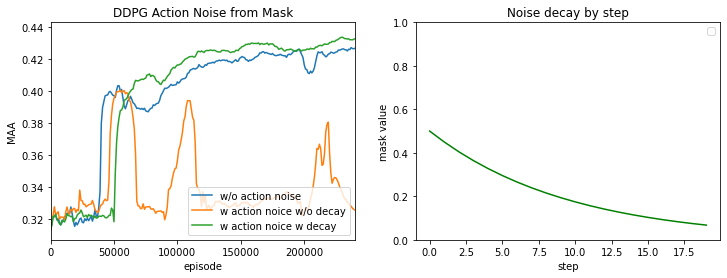

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
f,ax = plt.subplots(figsize=(12, 4), ncols=2)  

df = pd.read_csv('rl_baseline_skip_8_16.csv', header=None)
ax[0].plot(df[0],df[1], label = 'w/o action noise')
print('best test without noise', df[1].max())

df = pd.read_csv('rl_baseline_skip_8_16_40__noise0.5_nodecay.csv', header=None)
ax[0].plot(df[0],df[1], label = 'w action noice w/o decay')

df = pd.read_csv('rl_baseline_skip_8_16_40__noise0.5_decay0.9.csv', header=None)
ax[0].plot(df[0],df[1], label = 'w action noice w decay')
print('best test with noise decay',df[1].max())

ax[0].legend(loc='lower right')
ax[0].set_title('DDPG Action Noise from Mask')
ax[0].set_xlim(0,240000)

ax[0].set_xlabel('episode')
ax[0].set_ylabel('MAA')


steps = [*range(0, 20, 1)] 
dropout = [0.5*(0.9)**s for s in steps]

ax[1].plot(steps,dropout, color = 'green')
    
plt.legend()
plt.title('Noise decay by step')
ax[1].set_ylim(0,1)

plt.xlabel('step')
plt.ylabel('mask value')

In [13]:
skip_test_actual.mean()

0.5524

In [14]:
#random binary baseline
p = skip_test_actual.mean()
A=np.array([p]*10)
L=np.array([p]*10)
T=10
MAA = np.sum(A*L)/T
print(MAA)

0.30514575999999993


In [18]:
# Baseline loss
loss = -p*(np.log(p))
print(loss)

0.32783993045372284
